# Cleaning East River Stem Geolocation Shapefiles
**Author:** 'Marshall Worsham' <br>
**Creation Date:** '09/21/2020' <br>
**Revision Date:** '12/22/2020' <br>

---

## Table of Contents

1 - [Front matter](#front)<br>
2 - [Import stem geolocation shapefiles](#import)<br>

---

## Front matter<a id='front'></a>

This notebook contains markdown and code for post-processing point shapefiles generated from Trimble Geo7X GPS acquisitions in the East River domain. The input is a set of shapefiles containing tree geolocation points, one set for each site in the watershed where stem geolocations were acquired from 2018–2020.

The script appends the `Site` name and `subdirectory` to each shapefile name, then selects all projected point shapefiles, groups them by `Site` name, and merges points from the same site. It then filters out undesired points (e.g., plot corners and plot edges)

The script was developed in `Python 3.8.2` on a Macbook Pro 2014 running OSX 10.14.6.


### Libraries<a id='libraries'></a>

In [2]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import math
import re
from matplotlib import pyplot as plt
from os.path import join, getsize
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

### Define the working directories and list contents

In [4]:
directory = os.sep.join(['/Volumes', 'GoogleDrive', 'My Drive', 'Research', 'RMBL', 'Working_Files', 'Forest_Inventory_Dataset'])
source_dir = os.sep.join([directory, 'Source'])
scratch_dir = os.sep.join([directory, 'Scratch'])
out_dir = os.sep.join([directory, 'Output'])
stem_dir = os.sep.join([scratch_dir, 'GPS_Data_2021_MERGEDBYPLOT'])
os.listdir(stem_dir)[0:10]

['CC-EMN1.shp',
 'CC-EMN1.shx',
 'CC-EMN1.dbf',
 'CC-EMN1.cpg',
 'CC-EMN1.prj',
 'XX-CAR3.shp',
 'XX-CAR3.shx',
 'XX-CAR3.dbf',
 'XX-CAR3.cpg',
 'XX-CAR3.prj']

### Set pandas view to max rows and columns

In [5]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

## Import stem geolocation shapefiles<a id='import'></a>


In [6]:
# import the temp geodataframes from the append operations
stem_files = os.listdir(stem_dir)
stem_sf = [s for s in stem_files if s.endswith('.shp')]
stem_paths = [stem_dir + s for s in stem_sf]
appd_gpdf = []
for sf in stem_sf:
    gpdf = gpd.read_file(os.sep.join([stem_dir, sf]))
    appd_gpdf.append(gpdf)

## Plot
Plot the geodataframes to check they're functional

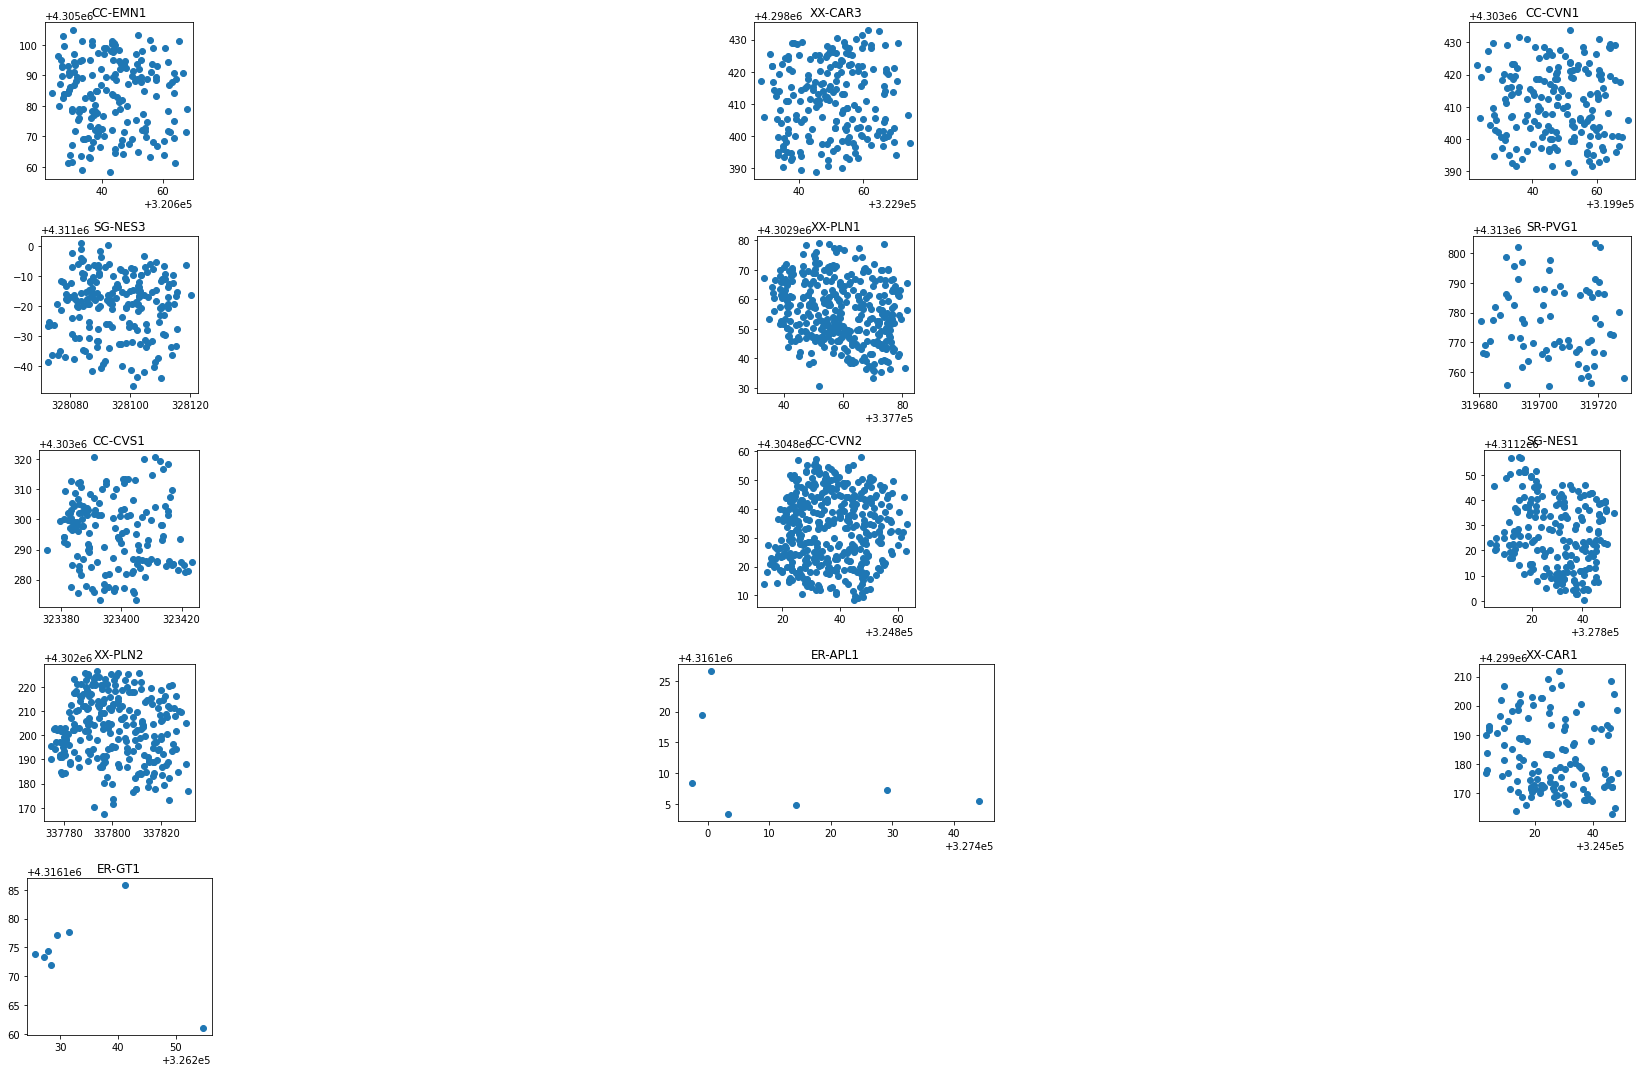

In [7]:
# Set a figure frame
plt.figure(figsize = (30,15))

# Plot the dataframes in sequence on the figure frame
for i, gpdf in enumerate(appd_gpdf):
    
    # create subplot axes in a 5x3 grid
    ax = plt.subplot(5, 3, i + 1) # nrows, ncols, axes position
    
    # set title
    ax.set_title(gpdf.Site[0])
    
    # plot the plot on these axes
    gpdf.plot(ax=ax)

plt.tight_layout();

NB: Some of the dataframes have extraneous points marking trailheads, trail exits, lunch spots, etc. We also know that some have duplicate records of a few tag numbers. We want to remove those and preserve only the points marking unique trees.

## Some functions to interact

In [6]:
# print ordered list of new geodataframes
print([i for i in stem_files if i.endswith('.shp')])

['Schofield-23.shp', 'Snodgrass-2.shp', 'Snodgrass-1.shp', 'Schofield-19.shp', 'PointLookout-1.shp', 'Schofield-24.shp', 'Schofield-5.shp', 'Schofield-4.shp', 'SplainsGulch-1.shp', 'ResearchMeadow.shp', 'Wash-1.shp', 'OhioPass-1.shp']


In [7]:
# # function to interact with dataframe
# def fh_interact(df):
#     '''
#     outputs sliders that show rows and cols of df
#     '''
#     def peek(row = 1, col = 0):
#         return df.iloc[row: row+10, col: col+10]
#     interact(peek, row = (0, len(df), 5), col = (0, len(df.columns) - 6))
#     print('({} rows, {} columns total'.format(df.shape[0], df.shape[1]))

## Define a function to generate new points based on geotag association notes in field notebooks and GPS units
For some trees that were growing very closely together, we did not geotag each tree individually with the GPS unit in order to save battery and complete the inventory. Instead, we left directional notes in the `Other` or `Other2` field. These comments had the format, e.g. "6030 0.4m NW". This indicated that for a given geotagged tree, #6030 was an ungeotagged associated tree standing 0.4m to the northwest of the geotagged tree. We define a function below that uses those notes to construct geolocation points for the trees that were associated through these notes.

In [8]:
def makenewpoint(gpdf, reftag, targtag, dir, distance):
    '''
    Creates new point geometries for stems that weren't geotagged but have directional and distance references in notes. 
    Inputs:
        - gpdf: geodataframe storing geometry and association data
        - reftag: an integer indicating the reference (geotagged) tree tag number
        - targtag: an integer indicating the target (untagged associated) tree tag number
        - dir: string indicating cardinal direction from reference to target (e,n,w,s,ne,nw,sw,se) noted in 'Other' or 'Other2' field
        - distance: float indicating distance from reference to target noted in 'Other' or 'Other2' field
    Returns:
        - geopandas entry with point geometry
    '''

    # Conversion from degrees to radians
    rad = np.pi/180

    # Calculate cardinal directions as radian angles from east-facing origin
    erad = rad*0
    nrad = rad*90
    wrad = rad*180
    srad = rad*270
    nerad = rad*45
    nwrad = rad*135
    swrad = rad*225
    serad = rad*315

    # Define radian direction based on cardinal direction input
    if dir == 'e':
        raddir = erad
    if dir == 'n':
        raddir = nrad
    if dir == 'w':
        raddir = wrad
    if dir == 's':
        raddir = srad
    if dir == 'ne':
        raddir = nerad
    if dir == 'nw':
        raddir = nwrad
    if dir == 'sw':
        raddir = swrad
    if dir == 'se':
        raddir = serad
    
    # Find x,y coordinates of reference tag number
    refcoords = gpdf[gpdf['GPS_Tag_Number'] == reftag].geometry
    x = refcoords.x
    y = refcoords.y

    # Calculate coordinates of target tag number
    x_prime = distance * np.cos(raddir) + x
    y_prime = distance * np.sin(raddir) + y
    
    # Create a new temp gpdf from new geometries   
    new_gdf = gpd.GeoDataFrame(geometry = gpd.points_from_xy(x_prime, y_prime, crs = 'epsg:32612'))
    new_gdf['GPS_Tag_Number'] = targtag
    new_gdf['Comment'] = 'Point generated post-campaign from geotag association note'
    new_gdf['GPS_Geotag_Association'] = ''
    new_gdf = new_gdf[['GPS_Tag_Number', 'Comment', 'GPS_Geotag_Association', 'geometry']]

    return new_gdf

---
## Clean  ER-BME1 - Schofield23 - appd_gpdf[0]

In [9]:
er_bme1 = appd_gpdf[0].copy()

In [10]:
# slice out any non-tree points by removing entries where 'Comment' != 'None'
er_bme1['Comment'] = [str(i) for i in er_bme1['Comment']]
er_bme1 = er_bme1.loc[er_bme1['Comment'] == 'None']

In [11]:
# create 'sp_code' field and populate with species code from 'Other' field
er_bme1['GPS_Sp_Code'] = [str(i).upper()[:4] for i in er_bme1['Other']]

# create 'Tag_Number' as first four elements in each 'Other2' entry
er_bme1['GPS_Tag_Number'] = [int(str(i)[:4]) for i in er_bme1['Other2']]

# create 'GPS_Geotag_Association'
er_bme1['GPS_Geotag_Association'] = [str(i).upper()[5:].strip('- ') for i in er_bme1['Other']]

In [12]:
er_bme1.reset_index(drop = True, inplace = True)

In [13]:
print(er_bme1['GPS_Geotag_Association'].unique())

['' '6233 50CM SW' '6227 50CM SE' '6287 10CM SE' '6240 10CM SW'
 '6246 40CM W' '1387 SAME BASE' '1383 SAME BASE' '\\' 'TOUCHING 6252'
 '1371 SAME BASE' '1376 SAME BASE' 'FELL NE PREVIOUSLY W/ 1336'
 'FELL EAST' '1277 SAME BASE' '6272 40CM SOUTH' '6230 30CM EAST'
 '6263 SAME BASE']


In [14]:
pts_to_add = er_bme1[er_bme1['GPS_Geotag_Association'] != ''][['GPS_Tag_Number', 'GPS_Geotag_Association']]
pts_to_add = pts_to_add[~pts_to_add['GPS_Tag_Number'].isin([1370,1337])]

In [15]:
pts_to_add

,GPS_Tag_Number,GPS_Geotag_Association
5,6234,6233 50CM SW
11,6228,6227 50CM SE
39,1388,6287 10CM SE
40,6241,6240 10CM SW
45,6245,6246 40CM W
46,1386,1387 SAME BASE
53,1382,1383 SAME BASE
62,1367,TOUCHING 6252
65,1372,1371 SAME BASE
69,1377,1376 SAME BASE


In [16]:
reftags = list(pts_to_add['GPS_Tag_Number'])
targtags = [6233, 6227, 6287, 6240, 6246, 1387, 1383, 6252, 1371, 1376, 1336, 1277, 6272, 6230, 6263]
dirs = ['sw', 'se', 'se', 'sw', 'w', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 's', 'e', 'e']
dists = [0.5, 0.5, 0.1, 0.1, 0.4, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.4, 0.3, 0.05]
assert len(reftags) == len(targtags) == len(dirs) == len(dists)

In [17]:
newpoints_ls = []
for reftag, targtag, dirc, dist in zip(reftags, targtags, dirs, dists):
    newpoint = makenewpoint(er_bme1, reftag, targtag, dirc, dist)
    newpoints_ls.append(newpoint)

In [18]:
er_bme1_clean = er_bme1.append(newpoints_ls, ignore_index=True)
er_bme1_clean['Site'] = 'ER-BME1'
er_bme1_clean = er_bme1_clean[[
    'Site',
    'GPS_Tag_Number',
    'GPS_Sp_Code',
    'Latitude',
    'Longitude',
    'GNSS_Heigh',
    'Horz_Prec',
    'Vert_Prec',
    'Std_Dev',
    'GPS_Time',
    'GPS_Date',
    'Rcvr_Type',
    'Corr_Type',
    'Max_PDOP',
    'Max_HDOP',
    'GPS_Geotag_Association',
    'Comment',
    'geometry'
    ]]

In [19]:
# Clean up blanks and Nones
er_bme1_clean.replace(['', 'None'], np.nan, inplace = True)

In [20]:
er_bme1_clean[er_bme1_clean.duplicated('GPS_Tag_Number', keep = False)]

,Site,GPS_Tag_Number,GPS_Sp_Code,Latitude,Longitude,GNSS_Heigh,Horz_Prec,Vert_Prec,Std_Dev,GPS_Time,GPS_Date,Rcvr_Type,Corr_Type,Max_PDOP,Max_HDOP,GPS_Geotag_Association,Comment,geometry
52,ER-BME1,1383,ABLA,38.976144246,-107.030339248,3339.613,1.9,2.0,1.286924,08:29:12am,2020-08-19,Geo 7X,Postprocessed Code,5.9,3.9,NaN,NaN,POINT (324123.469 4316089.124)
63,ER-BME1,6252,ABLA,38.976087049,-107.030395671,3338.826,1.5,1.4,0.898822,08:43:58am,2020-08-19,Geo 7X,Postprocessed Code,9.9,4.5,NaN,NaN,POINT (324118.439 4316082.885)
142,ER-BME1,1336,PIEN,38.976006784,-107.030390026,3335.575,1.3,2.4,0.792986,09:36:48am,2020-08-19,Geo 7X,Postprocessed Code,9.5,1.9,NaN,NaN,POINT (324118.729 4316073.966)
206,ER-BME1,1383,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Point generated post-campaign from geotag asso...,POINT (324125.585 4316090.690)
207,ER-BME1,6252,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Point generated post-campaign from geotag asso...,POINT (324118.397 4316082.201)
210,ER-BME1,1336,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Point generated post-campaign from geotag asso...,POINT (324120.322 4316073.398)


In [21]:
# Drop duplicates, preserving those with best horizontal precision
er_bme1_clean.drop([206,207,210], inplace = True)
er_bme1_clean.reset_index(drop=True, inplace = True)

In [22]:
er_bme1_clean['GPS_Tag_Number'] = pd.to_numeric(er_bme1_clean['GPS_Tag_Number'])

(212, 18)


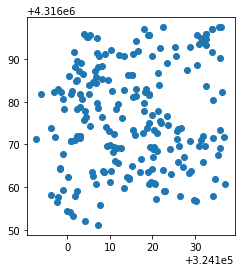

In [23]:
# plot to check
print(er_bme1_clean.shape)
er_bme1_clean.plot();

---
## Clean SG-NES2 - Snod-2 - appd_gpdf[1]

In [24]:
sg_nes2 = appd_gpdf[1].copy()

In [25]:
# slice out any non-tree points by removing entries where 'Comment' != 'None'
sg_nes2['Comment'] = [str(i) for i in sg_nes2['Comment']]
sg_nes2 = sg_nes2.loc[sg_nes2['Comment'] == 'None']
sg_nes2.reset_index(drop=True, inplace = True) # reset index

In [26]:
#sg_nes2

In [27]:
# create 'Sp_code' field and populate with species code from 'Other' field
sg_nes2['GPS_Sp_Code'] = [str(i).upper()[:4] for i in sg_nes2['Other']]

# create 'Tag_Number' as first four elements in each 'Other2' entry
sg_nes2['GPS_Tag_Number'] = [str(i)[:4] for i in sg_nes2['Other2']]

# create 'GPS_Geotag_Association'
sg_nes2['GPS_Geotag_Association'] = [str(i).upper()[i.index('-')+2:] if ('-') in i else '' for i in sg_nes2['Other']]

In [28]:
# slice out any trees with 'nt' and 'None' tags
sg_nes2 = sg_nes2.loc[~sg_nes2['GPS_Tag_Number'].str.contains('nt', na = False)]
sg_nes2 = sg_nes2.loc[~sg_nes2['GPS_Tag_Number'].str.contains('None', na = False)]

In [29]:
sg_nes2.loc[sg_nes2['GPS_Sp_Code'] == '49 .', ['GPS_Sp_Code']] = 'ABLA'
sg_nes2.loc[sg_nes2['GPS_Sp_Code'] == 'UNK4', ['GPS_Sp_Code']] = 'UNKN'
sg_nes2.loc[sg_nes2['GPS_Sp_Code'] == '5853', ['GPS_Sp_Code']] = 'ABLA'
sg_nes2.loc[sg_nes2['GPS_Tag_Number'] == 'abla', ['GPS_Tag_Number']] = 5853
sg_nes2.loc[sg_nes2['GPS_Sp_Code'] == 'LABL', ['GPS_Sp_Code']] = 'ABLA'

In [30]:
sg_nes2['GPS_Tag_Number'] = pd.to_numeric(sg_nes2['GPS_Tag_Number'])

In [31]:
sg_nes2['GPS_Sp_Code'].unique()

array(['PIEN', 'ABLA', 'PICO', 'UNKN'], dtype=object)

In [32]:
sg_nes2['GPS_Tag_Number'].unique()

array([5781, 5782, 6036, 5789, 5788, 5780, 5784, 5787, 5797, 6043, 5786,
       5770, 5769, 5800, 5768, 5767, 5747, 5738, 5739, 5740, 5766, 5765,
       5764, 5749, 5714, 5752, 5751, 5750, 3314, 3315, 3316, 3318, 3317,
       3319, 3320, 3321, 3322, 3323, 3324, 3326, 3327, 3329, 3332, 3334,
       3337, 3335, 3338, 3339, 3340, 3341, 3343, 3344, 3346, 3355, 3356,
       3357, 3358, 3351, 3349, 3348, 3347, 3353, 3359, 3360, 3363, 3364,
       3367, 3369, 3368, 3372, 3371, 3373, 3374, 3375, 3377, 3378, 3379,
       3380, 5718, 6011, 5719, 5721, 5720, 6012, 5724, 5725, 5726, 5727,
       6013, 5730, 5731, 6014, 5729, 5754, 6021, 6020, 6022, 6023, 6024,
       6026, 6027, 5762, 6029, 6028, 5849, 5763, 6030, 5839, 6031, 5799,
       5840, 5794, 5793, 5792, 5791, 5790, 6044, 5855, 5856, 5858, 5857,
       5884, 5861, 5862, 5863, 5865, 6041, 5866, 5867, 6040, 5869, 5870,
       5868, 5845, 5844, 6039, 5843, 3437, 3438, 3454, 3439, 3440, 3445,
       3450, 3455, 3456, 3458, 3459, 3461, 3463, 34

In [33]:
pts_to_add = sg_nes2[(sg_nes2['Other'].str.contains('-')) | (sg_nes2['Other2'].str.contains('-'))][['GPS_Tag_Number', 'Other', 'Other2']]
pts_to_add = pts_to_add[~pts_to_add['GPS_Tag_Number'].isin([5782,6011,5719,5854,5853,6038,5707])]

#pts_to_add = pts_to_add[~pts_to_add['GPS_Tag_Number'].isin([1370,1337])]

In [34]:
pts_to_add

,GPS_Tag_Number,Other,Other2
62,3324,abla - 3325 touching,3324 - 25
64,3327,pien - 3328 30cm west,3327 - 28
65,3329,abla - 3330 20cm sw,3329 - 30
66,3332,abla - 3331 20cm n; 3333 80cm sw,3332 - 31; 33
68,3337,abla - 3336 20cm sw,3337 - 36
73,3341,pien - 3342 shares base,3341 - 42
75,3344,abla - 3345 shares base,3344 - 45
77,3355,pien - 3354 50cm s,3355 - 54
81,3351,pien - 3352 same base,3351 - 52
82,3349,"abla - 3350, 5723 share base",3349 - 50


In [35]:
reftags = list(pts_to_add['GPS_Tag_Number']) + [3332, 3349, 3445, 3445, 3445, 3445, 3445, 3445, 3445, 3450, 3461, 3472, 3479, 3479, 3260, 3265, 3226, 3308, 3308, 3388, 3388, 3405, 3418]

targtags = [3325, 3328, 3330, 3333, 3336, 3342, 3345, 3354, 3352, 3350, 3361, 3362, 3365, 3366, 3370, 3376, 3453, 3449, 3451, 3457, 3460, 3464, 3473, 3477, 3481, 3484, 3497, 3508, 3517, 3259, 3261, 3266, 3287, 3296, 3304, 3309, 3311, 3224,3241,3386, 3390, 3393, 3397, 3400,3406, 3408, 3419,3416,3424,3428,3429, 3524, 3534, 3333, 5723, 3441,3442,3443,3444,3446,3447,3448,3452,3462,3471,3476,3475,3258,3268,3307,3310,3225,3389,3391,3407,3417]

dirs = ['e', 'w', 'sw', 'sw', 'sw', 'e', 'e', 's', 'e', 'e', 'e', 'nw', 's', 'e', 'nw', 'sw', 'e', 'e', 'e', 'e', 'n', 'e', 'se', 's', 'se', 'nw', 'e', 'e', 'sw', 'e', 'n', 'w', 'w', 'w', 'sw', 'sw', 'n', 'se', 'n', 'w', 'sw', 'e', 'e', 'sw', 'w', 'sw', 'e', 'e', 'se', 'se', 'e', 's', 'e', 'sw', 'e', 's', 'sw', 'w', 'w', 'se', 'se', 'e', 'w', 'nw', 'sw', 'sw', 'nw', 'w', 'w', 'e', 'w', 'n', 'n', 'se', 'nw', 'n']

dists = [0.05, 0.3, 0.2, 0.2, 0.2, 0.05, 0.05, 0.5, 0.05, 0.05, 0.3, 0.5, 0.8, 0.05, 0.5, 0.15, 0.05, 0.5, 0.05, 0.05, 1,0.05, 0.3, 0.15, 0.2, 0.2, 0.15, 0.05, 0.2, 1, 0.4, 0.5, 0.1, 1, 0.8, 0.2, 0.3, 0.5, 0.3, 0.15, 0.5, 0.05, 1, .8, .5, .05, .05, .05, .5, .3, .05, .4, .05,.8, 0.05, .5, .4, .5, .4, .4, 1, 1, 0.5, 0.5, 1, 0.4, 0.5, 0.6, 0.8, 0.2, 0.5, 0.5, 0.5, 0.1, 0.5, 0.2]

assert len(reftags) == len(targtags) == len(dirs) == len(dists)

In [36]:
newpoints_ls = []
for reftag, targtag, dirc, dist in zip(reftags, targtags, dirs, dists):
    newpoint = makenewpoint(sg_nes2, reftag, targtag, dirc, dist)
    newpoints_ls.append(newpoint)

In [37]:
sg_nes2_clean = sg_nes2.append(newpoints_ls, ignore_index=True)
sg_nes2_clean['Site'] = 'SG-NES2'
sg_nes2_clean = sg_nes2_clean[[
    'Site',
    'GPS_Tag_Number',
    'GPS_Sp_Code',
    'Latitude',
    'Longitude',
    'GNSS_Heigh',
    'Horz_Prec',
    'Vert_Prec',
    'Std_Dev',
    'GPS_Time',
    'GPS_Date',
    'Rcvr_Type',
    'Corr_Type',
    'Max_PDOP',
    'Max_HDOP',
    'GPS_Geotag_Association',
    'Comment',
    'geometry'
    ]]

In [38]:
# Print duplicates
sg_nes2_clean[sg_nes2_clean.duplicated(subset = 'GPS_Tag_Number', keep = False)]

,Site,GPS_Tag_Number,GPS_Sp_Code,Latitude,Longitude,GNSS_Heigh,Horz_Prec,Vert_Prec,Std_Dev,GPS_Time,GPS_Date,Rcvr_Type,Corr_Type,Max_PDOP,Max_HDOP,GPS_Geotag_Association,Comment,geometry
5,SG-NES2,5780,ABLA,38.930307593,-106.986957060,3328.981,0.5,0.7,0.058447,11:20:47am,2020-07-18,Geo 7X,Postprocessed Code,4.3,1.8,,None,POINT (327770.801 4310919.067)
6,SG-NES2,5784,ABLA,38.930328380,-106.986916965,3329.294,1.5,2.2,0.432360,11:22:41am,2020-07-18,Geo 7X,Postprocessed Code,4.4,2.3,,None,POINT (327774.327 4310921.298)
87,SG-NES2,5727,PIEN,38.930565485,-106.986696442,3340.086,1.5,2.0,0.187821,08:03:41am,2020-07-20,Geo 7X,Postprocessed Code,4.7,2.6,,None,POINT (327794.017 4310947.197)
103,SG-NES2,6028,ABLA,38.930392809,-106.986767025,3331.391,0.5,0.6,0.058008,09:10:00am,2020-07-20,Geo 7X,Postprocessed Code,2.7,1.5,,None,POINT (327787.480 4310928.166)
119,SG-NES2,5858,ABLA,38.930356116,-106.986652842,3337.194,0.5,0.6,0.035354,06:18:29am,2020-07-21,Geo 7X,Postprocessed Code,3.8,2.2,,None,POINT (327797.290 4310923.878)
120,SG-NES2,5857,PIEN,38.930327448,-106.986638096,3336.330,1.3,1.8,0.123688,06:20:19am,2020-07-21,Geo 7X,Postprocessed Code,3.8,1.9,,None,POINT (327798.499 4310920.668)
193,SG-NES2,6028,ABLA,38.930395995,-106.986771372,3337.094,1.0,1.7,0.149422,11:26:24am,2020-07-31,Geo 7X,Postprocessed Code,3.5,1.9,,None,POINT (327787.111 4310928.528)
194,SG-NES2,5722,UNKN,38.930529753,-106.986773719,3346.535,1.0,1.7,0.311198,11:28:00am,2020-07-31,Geo 7X,Postprocessed Code,3.5,1.2,,None,POINT (327787.231 4310943.377)
195,SG-NES2,5727,PIEN,38.930606751,-106.986723556,3349.837,0.9,1.7,0.246755,11:30:26am,2020-07-31,Geo 7X,Postprocessed Code,3.8,1.5,,None,POINT (327791.766 4310951.828)
215,SG-NES2,5858,ABLA,38.930372850,-106.986626058,3338.746,0.8,0.8,0.100627,10:41:05am,2020-07-20,Geo 7X,Postprocessed Code,2.7,1.3,,None,POINT (327799.652 4310925.684)


In [39]:
# Drop duplicates, preserving those with highest horizontal precision
sg_nes2_clean.drop([316, 6, 87, 193, 215, 120, 294, 487, 311, 486, 487], inplace = True)
er_bme1_clean.reset_index(drop=True, inplace = True)

In [40]:
# Clean up blanks and Nones
sg_nes2_clean.replace(['', 'None'], np.nan, inplace = True)

In [41]:
# Reset index
sg_nes2_clean.reset_index(drop = True, inplace = True)

In [42]:
# Make sure GPS Tag Number is numeric int64
sg_nes2_clean['GPS_Tag_Number'] = pd.to_numeric(sg_nes2_clean['GPS_Tag_Number'])
assert sg_nes2['GPS_Tag_Number'].dtype == 'int64'

(499, 18)


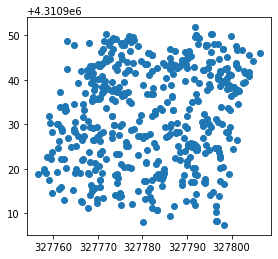

In [43]:
# Plot to check
print(sg_nes2_clean.shape)
sg_nes2_clean.plot();

## Clean SG-SWR1 - Snod-1 - appd_gpdf[2]

In [44]:
sg_swr1 = appd_gpdf[2].copy()

In [45]:
#sg_swr1

In [46]:
# create 'sp_code' field and populate with species code from 'Other' field
sg_swr1['GPS_Sp_Code'] = [str(i).upper()[:4] for i in sg_swr1['Other']]

# create 'Tag_Number' as first four elements in each 'Other2' entry
sg_swr1['GPS_Tag_Number'] = [str(i)[:4] for i in sg_swr1['Other2']]

# create 'GPS_Geotag_Association'
sg_swr1['GPS_Geotag_Association'] = [str(i).upper()[i.index('-')+2:] if ('-') in i else '' for i in sg_swr1['Other']]

In [47]:
# slice out any trees with 'nt' and 'None' tags
sg_swr1 = sg_swr1.loc[~sg_swr1['GPS_Tag_Number'].str.contains('nt', na = False)]
sg_swr1 = sg_swr1.loc[~sg_swr1['GPS_Tag_Number'].str.contains('None', na = False)]
sg_swr1.reset_index(drop=True, inplace = True) # reset index

In [48]:
sg_swr1['GPS_Tag_Number'] = pd.to_numeric(sg_swr1['GPS_Tag_Number'])

In [49]:
print(sg_swr1.GPS_Tag_Number.unique())
print(sg_swr1['GPS_Sp_Code'].unique())
print(sg_swr1.GPS_Geotag_Association.unique())

[5066 5065 5064 5057 6472 6473 6474 5063 5062 5059 5060 5061 5058 5020
 5021 5023 5022 5026 5025 5024 5027 5028 5041 5030 5039 5051 5144 5142
 5141 5140 5143 6475 5042 5043 5044 6476 5194 5192 5193 5196 5195 5208
 5207 5206 5209 5210 5216 5217 5219 5218 5215 5211 5213 5212 5200 5198
 5197 5199 6480 5214 5092 5090 5091 5096 5093 5094 5105 5104 5097 5098
 5089 5088 6481 6483 5126 5127 5128 5129 5130 5131 5132 5133 5134 5135
 5136 5170 5169 5167 5168 5201 5202 5204 5205 5203 5162 5163 5164 5165
 5166 5184 5185 5186 5187 5188 5189 5190 5191 4901 4903 4902 4905 4904
 4906 4907 4908 4909 4911 4910 4917 4916 4918 4913 4912 4920 4919 4921
 4922 4923 4924 4914 4925 4926 4928 4931 4932 4933 4934 4935 4936 4937
 4938 4939 4940 4941 4942 4943 4944 4945 4946 4947 4948 4949 4950 4951
 4953 3954 4955 4956 4957 4958 5009 6465 6466 6468 6467 6469 6470 5082
 5084 5083 5085 5086 5087 5080 6471 5078 5079 5081 5077 5018 5052 5053
 5054 5055 5056 5073 5072 5071 5074 5075 5070 5069 5068 5067 5137 6478
 5138 

In [50]:
pts_to_add = sg_swr1[(sg_swr1['Other'].str.contains('-')) | (sg_swr1['Other2'].str.contains('-'))][['GPS_Tag_Number', 'Other', 'Other2']]
pts_to_add = pts_to_add[~pts_to_add['GPS_Tag_Number'].isin([5208])]

In [51]:
pts_to_add

,GPS_Tag_Number,Other,Other2
119,4916,abla - 4915 15cm north,4916 2.0 - 15 1.4
132,4928,abla - 27 15cm se; 29 15cm e; 30 30cm ne,4928 - 27; 29; 30
154,4953,abla - 4952 10cm w,4953 4.0 - 52 2.4
221,4966,abla - 4967 15cm ne,4966 4.7 - 67 2.8


In [52]:
reftags = [4916, 4928, 4928, 4928, 4953, 4966]
targtags = [4915, 4927, 4929, 4930, 4952, 4967]
dirs = ['n', 'se', 'e', 'ne', 'w', 'ne']
dists = [0.15, 0.15, 0.15, 0.30, 0.10, 0.15]
assert len(reftags) == len(targtags) == len(dirs) == len(dists)

In [53]:
newpoints_ls = []
for reftag, targtag, dirc, dist in zip(reftags, targtags, dirs, dists):
    newpoint = makenewpoint(sg_swr1, reftag, targtag, dirc, dist)
    newpoints_ls.append(newpoint)

In [54]:
sg_swr1_clean = sg_swr1.append(newpoints_ls, ignore_index=True)
sg_swr1_clean['Site'] = 'SG-SWR1'
sg_swr1_clean = sg_swr1_clean[[
    'Site',
    'GPS_Tag_Number',
    'GPS_Sp_Code',
    'Latitude',
    'Longitude',
    'GNSS_Heigh',
    'Horz_Prec',
    'Vert_Prec',
    'Std_Dev',
    'GPS_Time',
    'GPS_Date',
    'Rcvr_Type',
    'Corr_Type',
    'Max_PDOP',
    'Max_HDOP',
    'GPS_Geotag_Association',
    'Comment',
    'geometry'
    ]]

In [55]:
# Print duplicates
sg_swr1_clean[sg_swr1_clean.duplicated(subset = 'GPS_Tag_Number', keep = False)]

,Site,GPS_Tag_Number,GPS_Sp_Code,Latitude,Longitude,GNSS_Heigh,Horz_Prec,Vert_Prec,Std_Dev,GPS_Time,GPS_Date,Rcvr_Type,Corr_Type,Max_PDOP,Max_HDOP,GPS_Geotag_Association,Comment,geometry
23,SG-SWR1,5030,PIEN,38.922105420,-106.984380425,3285.758,0.6,0.6,0.104180,09:04:55am,2020-07-29,Geo 7X,Postprocessed Code,3.0,1.5,,NaN,POINT (327974.346 4310003.893)
161,SG-SWR1,6465,POTR,38.922085683,-106.984597197,3285.481,0.4,0.5,0.030452,07:34:10am,2020-07-29,Geo 7X,Postprocessed Code,2.0,1.1,,NaN,POINT (327955.504 4310002.111)
162,SG-SWR1,6465,POTR,38.922095604,-106.984586602,3284.314,0.6,0.7,0.030766,07:38:44am,2020-07-29,Geo 7X,Postprocessed Code,2.6,1.5,,NaN,POINT (327956.447 4310003.192)
244,SG-SWR1,5030,PIEN,38.922144990,-106.984392973,3291.692,0.5,0.7,0.058587,08:43:07am,2020-07-28,Geo 7X,Postprocessed Code,2.8,1.5,,NaN,POINT (327973.353 4310008.308)


In [56]:
# Drop duplicates, preserving those with highest horizontal precision
sg_swr1_clean.drop([23, 162], inplace = True)

In [57]:
# Clean up blanks and Nones
sg_swr1_clean.replace(['', 'None'], np.nan, inplace = True)

In [58]:
# Reset index
sg_swr1_clean.reset_index(drop = True, inplace = True)

In [59]:
# Make sure GPS Tag Number is numeric int64
sg_swr1_clean['GPS_Tag_Number'] = pd.to_numeric(sg_swr1_clean['GPS_Tag_Number'])
assert sg_swr1_clean['GPS_Tag_Number'].dtype == 'int64'

(311, 18)


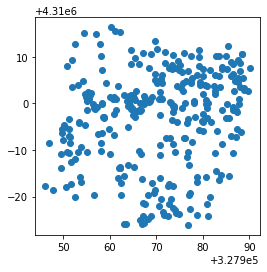

In [60]:
# Plot to check
print(sg_swr1_clean.shape)
sg_swr1_clean.plot();

---
## Clean ER-APL1 - Schofield 19 - appd_gpdf[3]

In [61]:
er_apl1 = appd_gpdf[3].copy()

In [62]:
# Slice out any non-tree points indicated in 'Comment' field
er_apl1 = er_apl1.loc[~er_apl1['Comment'].str.contains('road', na = False)]
er_apl1 = er_apl1.loc[~er_apl1['Comment'].str.contains('point', na = False)]
er_apl1 = er_apl1.loc[~er_apl1['Comment'].str.contains('parking', na = False)]
er_apl1.reset_index(drop=True, inplace = True) # reset index

In [63]:
# Manually clean inconsistent stem ID entries
er_apl1.at[er_apl1['Comment'] == '147', 'Comment'] = 'pe147'
er_apl1.at[er_apl1['Comment'] == 'ppe145', 'Comment'] = 'pe145'
er_apl1.at[er_apl1['Comment'] == '223', 'Comment'] = 'al223'
er_apl1.at[er_apl1['Comment'] == 'all176', 'Comment'] = 'al176'

In [64]:
er_apl1['Other'].replace([None], '', inplace = True)

In [65]:
# create 'sp_code' field and populate with species code from 'Other' field
er_apl1['GPS_Sp_Code'] = [str(i).upper()[:4] for i in er_apl1['Other']]
er_apl1['GPS_Sp_Code'] = ['ABLA' if (row['GPS_Sp_Code'] == '') and ('al' in row['Comment']) else row['GPS_Sp_Code'] for i,row in er_apl1.iterrows()]
er_apl1['GPS_Sp_Code'] = ['PIEN' if (row['GPS_Sp_Code'] == '') and ('pe' in row['Comment']) else row['GPS_Sp_Code'] for i,row in er_apl1.iterrows()]

# create 'Tag_Number' as first four elements in each 'Other2' entry
er_apl1['GPS_Tag_Number'] = [str(i)[:4] for i in er_apl1['Other2']]

# create 'GPS_Geotag_Association'
er_apl1['GPS_Geotag_Association'] = [str(i).upper()[i.index('-')+2:] if ('-') in i else '' for i in er_apl1['Other']]

In [66]:
#er_apl1

In [67]:
# Manually clean inconsistent GPS_Sp_Code entry (=7798)
er_apl1.at[er_apl1['GPS_Sp_Code'] == '7798', 'GPS_Sp_Code'] = 'UNKN'

In [68]:
#er_apl1['GPS_Tag_Number'] = pd.to_numeric(er_apl1['GPS_Tag_Number'])

In [69]:
print(er_apl1.GPS_Sp_Code.unique())
print(er_apl1.GPS_Tag_Number.unique())
print(er_apl1.GPS_Geotag_Association.unique())

['ABLA' 'PIEN' 'UNKN']
['7716' '7715' '7719' '7720' '7717' '7721' '7722' '7723' '7724' '7725'
 '7718' '7726' '7727' '7728' '7729' '7730' '7731' '7732' '7733' '7734'
 '7735' '7736' '7738' '7739' '7740' '7741' '7742' '7743' '7746' '7747'
 '7748' '7749' '7750' '7751' '7752' '7753' '7754' '7756' '7757' '7759'
 '7761' '7762' '7763' '7764' '7765' '7766' '7758' '7768' '7769' '7770'
 '7772' '7774' '7775' '7776' '7777' '7778' '7779' '7780' '7781' '7782'
 '7783' '7784' '7785' '7788' '7787' '7789' '7790' '7791' '7792' '7793'
 '7799' '7797' '7796' '7795' '7794' '7800' '7801' '7701' '7705' '7702'
 '7707' '7709' '7708' '7711' '7713' '7712' '7714' '6477' '6484' '6490'
 '6491' '6492' '6493' '6494' '6495' '6496' '6497' '6489' '6498' '6499'
 '6500' '6301' '6302' '6303' '6304' '6305' '6306' '6307' '6369' '6370'
 '6350' '6349' '6346' '6338' '6336' '6333' '6329' '6328' '6330' '6332'
 '6340' '6342' '6343' '6344' '6308' '6309' '6310' '6311' '6312' '6313'
 '6315' '6316' '6318' '6319' '6320' '6326' '6327' '632

In [70]:
pts_to_add = er_apl1[(er_apl1['Other'].str.contains('-')) | (er_apl1['Other2'].str.contains('-'))][['GPS_Tag_Number', 'Other', 'Other2']]

In [71]:
pts_to_add

,GPS_Tag_Number,Other,Other2
21,7736,abla - 7737 50cm north,7736 3.3 - 37 1.6
27,7743,pien - 7744 60cm n,7743 6.4 - 44 4
28,7746,pien - 7745 20cm ne,7746 5.7 - 45 1.8
37,7756,pien - 7755 10cm sw,7756 4.2 - 55 2.8
39,7759,abla - 7760 20cm ne,7759 4.7 - 60 1.2
45,7766,pien 7767 20cm nw,7766 2.8 - 67 2.9
49,7770,pien - 7771 20cm se,7770 5.8 - 71 2.9
51,7774,pien - 7773 10cm sw,7774 8.8 - 73 2.9
62,7785,pien - 7786 50cm se,7785 2.5 - 86 1.9
70,7799,7798 60cm sw,7799 4.7 - 98 3.1


In [72]:
pts_to_add['Targets'] = [i[i.index(' ')+3:] for i in pts_to_add['Other']]
pts_to_add['Targets'] = pts_to_add['Targets'].str.split(';')

In [73]:
reftags_tmp = []
for index, row in pts_to_add.iterrows():
    reftag = list(np.repeat(row['GPS_Tag_Number'], len(row['Targets'])))
    reftags_tmp.append(reftag)

In [74]:
targtags_tmp = [val for sublist in pts_to_add['Targets'] for val in sublist]
targtags_tmp2 = [i.strip(' ') for i in targtags_tmp]

In [75]:
targtags_tmp

[' 7737 50cm north',
 '7744 60cm n',
 '7745 20cm ne',
 '7755 10cm sw',
 '7760 20cm ne',
 '67 20cm nw',
 '7771 20cm se',
 '7773 10cm sw',
 '7786 50cm se',
 'cm sw',
 '7703 1m s',
 ' 7704 1m se',
 '7706 1m ne',
 '7710 20cm nw',
 '6348 1m n',
 ' 6347 1m nw',
 '39 50cm ne',
 ' 35 20cm se',
 ' 37 40cm nw',
 '34 .7m S',
 '6341 50cm n',
 '6303 10cm ne',
 '6314 30cm nw',
 '6317 1m se',
 '23 10cm e',
 ' 21 50cm ne',
 ' 24 50cm w',
 '6365 40cm s',
 '6368 40cm nw',
 '6372 50cm s',
 '6373 70cm ne',
 'touching 1072',
 '6204 touching',
 '6211 1m n',
 ' 6213 60cm w',
 '1415 50cm ne',
 ' 1417 30cm w',
 '1405 15cm sw',
 '1408 touching',
 '1436 20cm s',
 '1425 and 1427 all touching',
 '446 20cm s',
 '1449 touching',
 '1451 75cm nw',
 ' 1453 30cm w',
 ' 1461 50cm s',
 ' 1462 50cm sw']

In [76]:
targtags_tmp2 = [i.split(' ')[0] for i in targtags_tmp2]
targtags_tmp2 = ['7798' if x == 'cm' else x for x in targtags_tmp2]
targtags_tmp2 = ['1072' if x == 'touching' else x for x in targtags_tmp2]

In [77]:
dirs_tmp = [i.split(' ')[-1] for i in targtags_tmp]
dirs_tmp = ['e' if x == 'base' or x == 'touching' or x == '1' or x == '' else x for x in dirs_tmp]
dirs_tmp = ['w' if x == 'west' else x for x in dirs_tmp]
dirs_tmp = ['n' if x == 'north' else x for x in dirs_tmp]
dirs_tmp = ['s' if x == 'S' else x for x in dirs_tmp]
dirs_tmp = ['e' if x == '1072' else x for x in dirs_tmp]

In [78]:
reftags = [val for sublist in reftags_tmp for val in sublist] + ['1426']
targtags = targtags_tmp2 + ['1427']
dirs = dirs_tmp + ['e']
dists = [.5, .6, .2, .1, .2, .2, .2, .1, .5, .6, 1, 1, 1, .2, 1, 1, .5, .2, .4, .7, .5, .1, .3, .1, .1, .5, .5, .4, .4, .5, .7, .05, .05, 1, .6, .5, .3, .15, .05, .2, .05, .2, .05, .75, .3, .5, .5, .05]

assert len(reftags) == len(targtags) == len(dirs) == len(dists)

In [79]:
newpoints_ls = []
for reftag, targtag, dirc, dist in zip(reftags, targtags, dirs, dists):
    newpoint = makenewpoint(er_apl1, reftag, targtag, dirc, dist)
    newpoints_ls.append(newpoint)

In [80]:
er_apl1_clean = er_apl1.append(newpoints_ls, ignore_index=True)
er_apl1_clean['Site'] = 'ER-APL1'
er_apl1_clean = er_apl1_clean[[
    'Site',
    'GPS_Tag_Number',
    'GPS_Sp_Code',
    'Latitude',
    'Longitude',
    'GNSS_Heigh',
    'Horz_Prec',
    'Vert_Prec',
    'Std_Dev',
    'GPS_Time',
    'GPS_Date',
    'Rcvr_Type',
    'Corr_Type',
    'Max_PDOP',
    'Max_HDOP',
    'GPS_Geotag_Association',
    'Comment',
    'geometry'
    ]]

### Match tag numbers in inventory data

In [81]:
scho19_inv_2018 = pd.read_csv(os.sep.join([source_dir, 'Schofield_19_inventory_data_2018.csv']))

In [82]:
merge_df = scho19_inv_2018.loc[:,['Tree_#', 'Tree_Tag_#']].dropna()
merge_df['Tree_#'] = [str(i).lower() for i in merge_df['Tree_#']]
merge_df.columns = ['Comment', 'Tree_Tag_Number']

In [83]:
er_apl1_merged = er_apl1_clean.merge(merge_df, on = 'Comment', how = 'outer')
er_apl1_merged['GPS_Tag_Number'] = [row['Tree_Tag_Number'] if row['GPS_Tag_Number'] == 'None' else row['GPS_Tag_Number'] for i, row in er_apl1_merged.iterrows()]

In [84]:
er_apl1_clean = er_apl1_merged[er_apl1_merged['GPS_Tag_Number'] != 'NT'].drop(columns = 'Tree_Tag_Number')
er_apl1_clean = er_apl1_clean[er_apl1_clean['GPS_Tag_Number'].notna()]

In [85]:
# Reset index
er_apl1_clean.reset_index(drop = True, inplace = True)

In [86]:
# Print duplicates
er_apl1_clean[er_apl1_clean.duplicated(subset = 'GPS_Tag_Number', keep = False)]

,Site,GPS_Tag_Number,GPS_Sp_Code,Latitude,Longitude,GNSS_Heigh,Horz_Prec,Vert_Prec,Std_Dev,GPS_Time,GPS_Date,Rcvr_Type,Corr_Type,Max_PDOP,Max_HDOP,GPS_Geotag_Association,Comment,geometry
101,ER-APL1,6301,ABLA,38.977093988,-106.992051385,3056.609,1.5,1.9,0.280333,11:28:57am,2020-08-03,Geo 7X,Postprocessed Code,3.7,1.9,,None,POINT (327442.731 4316121.266)
102,ER-APL1,6302,ABLA,38.977079073,-106.991982521,3050.914,0.6,0.8,0.207083,11:33:32am,2020-08-03,Geo 7X,Postprocessed Code,3.1,1.4,,None,POINT (327448.661 4316119.480)
103,ER-APL1,6303,PIEN,38.977102701,-106.991974946,3052.667,1.4,2.2,1.271678,11:36:44am,2020-08-03,Geo 7X,Postprocessed Code,3.7,2.3,,None,POINT (327449.375 4316122.088)
104,ER-APL1,6304,PIEN,38.977030158,-106.992107550,3050.907,0.9,1.6,0.101780,11:38:10am,2020-08-03,Geo 7X,Postprocessed Code,3.6,1.3,,None,POINT (327437.711 4316114.288)
105,ER-APL1,6305,ABLA,38.977014826,-106.992101291,3048.843,0.6,0.7,0.100787,11:39:22am,2020-08-03,Geo 7X,Postprocessed Code,3.9,1.9,,None,POINT (327438.216 4316112.575)
106,ER-APL1,6306,ABLA,38.977005823,-106.992075417,3057.754,1.0,1.5,1.237312,11:42:57am,2020-08-03,Geo 7X,Postprocessed Code,3.1,1.2,,None,POINT (327440.435 4316111.526)
107,ER-APL1,6307,ABLA,38.977026313,-106.992079118,3054.996,0.8,1.2,0.241035,11:45:18am,2020-08-03,Geo 7X,Postprocessed Code,6.0,3.7,,None,POINT (327440.164 4316113.807)
110,ER-APL1,6301,ABLA,38.977040074,-106.992051582,3048.015,0.5,0.6,0.054913,06:40:23am,2020-08-18,Geo 7X,Postprocessed Code,2.8,1.7,,None,POINT (327442.583 4316115.282)
111,ER-APL1,6304,PIEN,38.977041402,-106.992075976,3048.320,0.6,0.8,0.205580,06:41:03am,2020-08-18,Geo 7X,Postprocessed Code,2.7,1.5,,None,POINT (327440.473 4316115.476)
112,ER-APL1,6305,ABLA,38.977018414,-106.992113810,3049.808,0.7,0.9,0.234339,06:41:36am,2020-08-18,Geo 7X,Postprocessed Code,3.0,1.7,,None,POINT (327437.140 4316112.996)


In [87]:
er_apl1_clean.at[439, 'GPS_Tag_Number'] = '1487'

In [88]:
# Drop duplicates, preserving those with highest horizontal precision
er_apl1_clean.drop([101, 102, 106, 491, 492, 111, 112, 107, 150, 502, 304, 321, 358, 359, 373, 419], inplace = True)

In [89]:
# Clean up blanks and Nones
er_apl1_clean.replace(['', 'None'], np.nan, inplace = True)

In [90]:
# Reset index
er_apl1_clean.reset_index(drop = True, inplace = True)

In [91]:
fixtag_indexer = er_apl1_clean[er_apl1_clean['GPS_Tag_Number'].str.len() <= 3].index

In [92]:
fixtag_indexer

Int64Index([462, 473, 474, 475, 476, 480, 481, 482, 496], dtype='int64')

In [93]:
fixtags = [7767, 6339, 6335, 6337, 6334, 6323, 6321, 6324, 1446]

In [94]:
er_apl1_clean.at[fixtag_indexer, 'GPS_Tag_Number'] = fixtags

In [95]:
# Make sure GPS Tag Number is numeric int64
er_apl1_clean['GPS_Tag_Number'] = pd.to_numeric(er_apl1_clean['GPS_Tag_Number'])
assert er_apl1_clean['GPS_Tag_Number'].dtype == 'int64'

(503, 18)


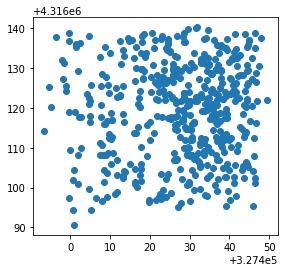

In [96]:
# Plot to check
print(er_apl1_clean.shape)
er_apl1_clean.plot();

---
## Clean XX-PLN1 - Point Lookout 1 - appd_gpdf[4]

In [97]:
xx_pln1 = appd_gpdf[4].copy()

In [98]:
#xx_pln1

In [99]:
# create 'sp_code' field and populate with species code from 'Other' field
spcode_tmp = [str(i).upper()[:4] if i.isalpha() or '-' in i or 'cm' in i or '?' in i else '' for i in xx_pln1['Other']]
spcode_tmp2 = [str(j).upper()[:4] if j.isalpha() or 'cm' in j or '?' in j else k for j,k in zip(xx_pln1['Other2'], spcode_tmp)]
xx_pln1['GPS_Sp_Code'] = spcode_tmp2

# create 'Tag_Number' as first four elements in each 'Other2' entry
tagnum_tmp = [str(i).upper()[:4] if i.isnumeric() or '-' in i else '' for i in xx_pln1['Other2']]
tagnum_tmp2 = [str(j).upper()[:4] if j.isnumeric() else k for j,k in zip(xx_pln1['Other'], tagnum_tmp)]
xx_pln1['GPS_Tag_Number'] = tagnum_tmp2

# create 'GPS_Geotag_Association'
gpsas_tmp = [str(i).upper()[i.index('-')+2:] if i[:4].isalpha() and '-' in i else '' for i in xx_pln1['Other']]
gpsas_tmp2 = [str(j).upper()[j.index('-')+2:] if j[:4].isalpha() and '-' in j else k for j,k in zip(xx_pln1['Other'], gpsas_tmp)]
xx_pln1['GPS_Geotag_Association'] = gpsas_tmp2

In [100]:
# A few species codes didn't populate over. They were all marked ABLA in one of the 'Other' fields, so we can manually assign them the value 'ABLA'
xx_pln1['GPS_Sp_Code'].replace('', 'ABLA', inplace = True)

# One stem is marked 'DEAD' in the comment field, so we need to replace that with UNKN for now – it may be correctly identified in the field notebooks.
xx_pln1['GPS_Sp_Code'].replace('DEAD', 'UNKN', inplace = True)

In [101]:
# Slice out any trees with 'nt' and 'None' tags
xx_pln1 = xx_pln1.loc[~xx_pln1['GPS_Tag_Number'].str.contains('nt', na = False)]
xx_pln1 = xx_pln1.loc[~xx_pln1['GPS_Tag_Number'].str.contains('None', na = False)]
xx_pln1.reset_index(drop=True, inplace = True) # reset index

In [102]:
xx_pln1['GPS_Tag_Number'] = pd.to_numeric(xx_pln1['GPS_Tag_Number'])

In [103]:
print(xx_pln1.GPS_Sp_Code.unique())
print(xx_pln1.GPS_Tag_Number.unique())

['ABLA' 'UNKN' 'POTR' 'PIEN' 'PSME' 'PICO']
[6621 6622 6623 6624 6626 6627 6628 6629 6631 6632 6633 6638 6636 6635
 6640 6641 6639 6642 6142 6648 6646 6647 6649 6625 6613 6619 6620 6616
 6141 6612 6645 6144 6139 6143 6669 6670 6667 6668 6666 6147 6665 6661
 6146 6662 6655 6138 6656 6654 6145 6652 6650 6651 6653 6657 6659 6660
 6658 6609 6610 6611 6132 6590 6589 6672 6673 6671 6591 6133 6594 6595
 6586 6596 6585 6131 6592 6664 6597 6598 6134 6135 6136 6663 6600 6137
 6599 6130 6601 6602 6572 6571 6570 6121 6124 6123 6615 6122 6573 6576
 6577 6125 6140 6574 6575 6579 6127 6580 6581 6582 6128 6584 6129 6583
 6578 6126 6608 6607 6604 6606 6605 6603 6545 6107 6106 6546 6587 6588
 6547 6548 6108 6549 6550 6109 6552 6553 6091 6110 6092 6556 6558 6557
 6563 6120 6569 6119 6568 6117 6562 6115 6116 6567 6566 6564 6561 6560
 6113 6114 6112 6559 6111 6674]


In [104]:
pts_to_add = xx_pln1[(xx_pln1['Other'].str.contains('-')) | (xx_pln1['Other2'].str.contains('-'))][['GPS_Tag_Number', 'Other', 'Other2']]

In [105]:
pts_to_add

,GPS_Tag_Number,Other,Other2
8,6631,potr 6631 5cm east,6631 - 30
10,6633,abla - 6634 1m north west,6633 - 34
12,6636,potr - 6637 10cm north,6636 - 37
24,6613,abla - 6617 1m ne,6613 - 17
25,6619,unknown - 6618 10cm sw,6619 - 18
121,6107,6107,abla - 6551 0.4m N
135,6110,6110,abla - 6554 0.5m N
146,6117,abla - 6118 same base,6117 - 18
151,6566,abla - same base,6566 - 65


In [106]:
reftags = [6631, 6633, 6636, 6613, 6619, 6107, 6110, 6117, 6566]
targtags = [6630, 6634, 6637, 6617, 6618, 6551, 6554, 6118, 6565]
dirs = ['e', 'nw', 'n', 'ne', 'sw', 'n', 'n', 'e', 'e']
dists = [0.05, 1.0, 0.10, 1.0, 0.10, 0.40, 0.50, 0.05, 0.05]
assert len(reftags) == len(targtags) == len(dirs) == len(dists)

In [107]:
newpoints_ls = []
for reftag, targtag, dirc, dist in zip(reftags, targtags, dirs, dists):
    newpoint = makenewpoint(xx_pln1, reftag, targtag, dirc, dist)
    newpoints_ls.append(newpoint)

In [108]:
xx_pln1_clean = xx_pln1.append(newpoints_ls, ignore_index=True)
xx_pln1_clean['Site'] = 'XX-PLN1'
xx_pln1_clean = xx_pln1_clean[[
    'Site',
    'GPS_Tag_Number',
    'GPS_Sp_Code',
    'Latitude',
    'Longitude',
    'GNSS_Heigh',
    'Horz_Prec',
    'Vert_Prec',
    'Std_Dev',
    'GPS_Time',
    'GPS_Date',
    'Rcvr_Type',
    'Corr_Type',
    'Max_PDOP',
    'Max_HDOP',
    'GPS_Geotag_Association',
    'Comment',
    'geometry'
    ]]

In [109]:
# Print duplicates
xx_pln1_clean[xx_pln1_clean.duplicated(subset = 'GPS_Tag_Number', keep = False)]

,Site,GPS_Tag_Number,GPS_Sp_Code,Latitude,Longitude,GNSS_Heigh,Horz_Prec,Vert_Prec,Std_Dev,GPS_Time,GPS_Date,Rcvr_Type,Corr_Type,Max_PDOP,Max_HDOP,GPS_Geotag_Association,Comment,geometry
137,XX-PLN1,6556,ABLA,38.860595668,-106.870015325,3007.543,0.7,0.7,0.219825,08:13:00am,2020-08-25,Geo 7X,Postprocessed Code,3.7,2.9,,NaN,POINT (337749.527 4302967.832)
138,XX-PLN1,6556,ABLA,38.860592985,-106.869996984,3009.597,0.6,0.7,0.379208,08:14:22am,2020-08-25,Geo 7X,Postprocessed Code,2.8,1.6,,NaN,POINT (337751.112 4302967.502)


In [110]:
# Drop duplicates, preserving those with highest horizontal precision
xx_pln1_clean.drop([137], inplace = True)

In [111]:
# Clean up blanks and Nones
xx_pln1_clean.replace(['', 'None'], np.nan, inplace = True)

In [112]:
# Reset index
xx_pln1_clean.reset_index(drop = True, inplace = True)

In [113]:
# Make sure GPS Tag Number is numeric int64
xx_pln1_clean['GPS_Tag_Number'] = pd.to_numeric(xx_pln1_clean['GPS_Tag_Number'])
assert xx_pln1_clean['GPS_Tag_Number'].dtype == 'int64'

(169, 18)


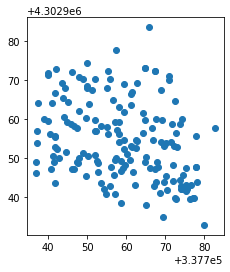

In [114]:
# Plot to check
print(xx_pln1_clean.shape)
xx_pln1_clean.plot();

---
## Clean ER-GT1 - Schofield 24 - appd_gpdf[5]

In [115]:
er_gt1 = appd_gpdf[5].copy()

In [116]:
er_gt1.Comment.unique()

array(['al273', 'al274', 'al275', 'al276', 'al277', 'pe55', 'pe56',
       'pe57', 'al278', 'al279', 'pe58', 'al280', 'al281', 'al282',
       'al283', 'al284', 'al285', 'al286', 'pe59', 'pe60', 'pe61',
       'al287', 'al288', 'al289', 'al290', 'al291', 'al292', 'al293',
       'al294', 'al295', 'al296', 'al297', 'al298', 'al299', 'al300',
       'al301', 'al302', 'al303', 'pe62', 'al304', 'al305', 'al306',
       'pe63', 'al307', 'al308', 'al309', 'al310', 'al311', 'al312',
       'pe64', 'pe65', 'pe66', 'al313', 'al314', 'al315', 'al316',
       'al317', 'al318', 'al319', 'al320', 'al321', 'al322', 'al323',
       'al324', 'al325', 'pe67', 'al326', 'al327', 'al328', 'al329',
       'al330', 'pe68', 'al331', 'pe69', 'pe70', 'pe71', 'al332', 'al333',
       'pe72', 'al334', 'al335', 'al336', 'al337', 'al338', 'al339',
       'al340', 'al341', 'al342', 'al343', 'al344', 'al345', 'al346',
       'al347', 'al348', 'al349', 'al350', 'al351', 'al352', 'al353',
       'al354', 'al355', 'pe7

In [117]:
# Slice out any non-tree points indicated in 'Comment' field
er_gt1 = er_gt1.loc[~er_gt1['Comment'].str.contains('center', na = False)]

# Slice out any non-tree points indicated in 'Other' field
er_gt1 = er_gt1.loc[~er_gt1['Other'].str.contains('corner', na = False)]

er_gt1.reset_index(drop=True, inplace = True) # reset index

In [118]:
# Change 'None' entries to ''
er_gt1['Other'].replace([None], '', inplace = True)
er_gt1['Other2'].replace([None], '', inplace = True)
er_gt1['Comment'].replace([None], '', inplace = True)

In [119]:
# Some tree numbers in 'Comment' field have extraneous letter values at the end, mostly 's' and 'oo'. We remove them to match with inventory numbers later on
er_gt1['Comment'] = [i.strip('s') for i in er_gt1['Comment']]
er_gt1['Comment'] = [i.strip('y') for i in er_gt1['Comment']]
er_gt1['Comment'] = [i.strip('oo') for i in er_gt1['Comment']]

In [120]:
er_gt1.Other2.unique()

array(['', '3001', '3002', '3004', '3005', '3003', '3007', '3006', '3010',
       '3009', '3008', '3012', '3011', '3013', '3014', '3015', '3017',
       '3016', '3018', '3019', '3020', '3021', '3022', '3024', '3025',
       '3026', '3027', '3028', '3029', '3030', '3031', '3032', '3033',
       '11', '17', '3035', '3034', '3036', '3038', '3037', '3039', '3040',
       '3041', '3042', '3043', '3044', '3045', '3046', '3047', '3048',
       '3049', '3050', '3051', '3054', '3053', '3052', '3055', '3056',
       '3058', '3060', '3062', '3064', '3066', '3067', '3068', '3069',
       '3070', '3071', '3072', '3073', '3074', '3075', '3076', '3077',
       '3078', '3079', '3080', '3081', '3082', '3083', '3084', '3085',
       '3086', '3087', '3088', '332', '321', '3091', '3092', '3090',
       '3093', '3094', '3095', '3096', '3097', '3098', '3099', '3100',
       '3101', '3102', '3103', '3104', '3105', '3106', '3107', '3108',
       '3109', '3110', '3111', '3112', '3113', '3114', '3115', '3116',


In [121]:
# create 'sp_code' field and populate with species code from 'Other' field
er_gt1['GPS_Sp_Code'] = [str(i).upper()[:4] for i in er_gt1['Other']]
er_gt1['GPS_Sp_Code'] = ['ABLA' if (row['GPS_Sp_Code'] == '') and ('al' in row['Comment']) else row['GPS_Sp_Code'] for i,row in er_gt1.iterrows()]
er_gt1['GPS_Sp_Code'] = ['PIEN' if (row['GPS_Sp_Code'] == '') and ('pe' in row['Comment']) else row['GPS_Sp_Code'] for i,row in er_gt1.iterrows()]

# create 'Tag_Number' as first four elements in each 'Other2' entry
er_gt1['GPS_Tag_Number'] = [str(i)[:4] for i in er_gt1['Other2']]

# create 'GPS_Geotag_Association'
er_gt1['GPS_Geotag_Association'] = [str(i).upper()[i.index('-')+2:] if ('-') in i else '' for i in er_gt1['Other']]

In [122]:
# Manually correct empty GPS_Sp_Code entry 
er_gt1.at[er_gt1['GPS_Sp_Code'] == '', 'GPS_Sp_Code'] = 'UNKN'

In [123]:
print(er_gt1.GPS_Sp_Code.unique())
print(er_gt1.GPS_Tag_Number.unique())
print(er_gt1.GPS_Geotag_Association.unique())

['ABLA' 'PIEN' 'UNKN']
['' '3001' '3002' '3004' '3005' '3003' '3007' '3006' '3010' '3009' '3008'
 '3012' '3011' '3013' '3014' '3015' '3017' '3016' '3018' '3019' '3020'
 '3021' '3022' '3024' '3025' '3026' '3027' '3028' '3029' '3030' '3031'
 '3032' '3033' '11' '17' '3035' '3034' '3036' '3038' '3037' '3039' '3040'
 '3041' '3042' '3043' '3044' '3045' '3046' '3047' '3048' '3049' '3050'
 '3051' '3054' '3053' '3052' '3055' '3056' '3058' '3060' '3062' '3064'
 '3066' '3067' '3068' '3069' '3070' '3071' '3072' '3073' '3074' '3075'
 '3076' '3077' '3078' '3079' '3080' '3081' '3082' '3083' '3084' '3085'
 '3086' '3087' '3088' '332' '321' '3091' '3092' '3090' '3093' '3094'
 '3095' '3096' '3097' '3098' '3099' '3100' '3101' '3102' '3103' '3104'
 '3105' '3106' '3107' '3108' '3109' '3110' '3111' '3112' '3113' '3114'
 '3115' '3116' '3117' '3118' '3119' '3120' '3121' '3122' '3123' '63'
 '3124' '3125' '3126' '3089' '3127' '3129' '3130' '3128' '3131' '3132'
 '3134' '3133' '3135' '3136' '3137' '3138' '3139' '3

In [124]:
pts_to_add = er_gt1[(er_gt1['Other'].str.contains('-')) | (er_gt1['Other2'].str.contains('-'))][['GPS_Tag_Number', 'Other', 'Other2']]

In [125]:
pts_to_add

,GPS_Tag_Number,Other,Other2
154,3022,abla - 3023 20cm sw,3022
190,3058,abla - 3057 50cm sw,3058
191,3060,abla - 3059 20cm w,3060
192,3062,abla - 3061 50cm ne,3062
193,3064,abla - 3063 75cm nw; 3065 1m w,3064


In [126]:
reftags = [3022, 3058, 3060, 3062, 3064, 3064]
targtags = [3023, 3057, 3059, 3061, 3063, 3065]
dirs = ['sw', 'sw', 'w', 'ne', 'nw', 'w']
dists = [.2, .5, .2, .5, .75, 1]

In [127]:
newpoints_ls = []
for reftag, targtag, dirc, dist in zip(reftags, targtags, dirs, dists):
    newpoint = makenewpoint(er_gt1, reftag, targtag, dirc, dist)
    newpoints_ls.append(newpoint)

In [128]:
er_gt1_clean = er_gt1.append(newpoints_ls, ignore_index=True)
er_gt1_clean['Site'] = 'ER-GT1'
er_gt1_clean = er_gt1_clean[[
    'Site',
    'GPS_Tag_Number',
    'GPS_Sp_Code',
    'Latitude',
    'Longitude',
    'GNSS_Heigh',
    'Horz_Prec',
    'Vert_Prec',
    'Std_Dev',
    'GPS_Time',
    'GPS_Date',
    'Rcvr_Type',
    'Corr_Type',
    'Max_PDOP',
    'Max_HDOP',
    'GPS_Geotag_Association',
    'Comment',
    'geometry'
    ]]

### Match tag numbers to inventory sheets

In [129]:
scho24_inv_2018 = pd.read_csv(os.sep.join([source_dir, 'Schofield_24_inventory_data_2018.csv']))

In [130]:
merge_df = scho24_inv_2018.loc[:,['Tree_#', 'Tree_Tag_#']].dropna()
merge_df['Tree_#'] = [str(i).lower() for i in merge_df['Tree_#']]
merge_df.columns = ['Comment', 'Tree_Tag_Number']

In [131]:
er_gt1_merged = er_gt1_clean.merge(merge_df, on = 'Comment', how = 'outer')
er_gt1_merged['GPS_Tag_Number'] = [row['Tree_Tag_Number'] if row['GPS_Tag_Number'] == '' else row['GPS_Tag_Number'] for i, row in er_gt1_merged.iterrows()]

In [132]:
er_gt1_clean = er_gt1_merged[er_gt1_merged['GPS_Tag_Number'] != 'NT'].drop(columns = 'Tree_Tag_Number')
er_gt1_clean = er_gt1_clean[er_gt1_clean['GPS_Tag_Number'].notna()]

In [133]:
er_gt1_clean.GPS_Tag_Number.unique()

array(['353', '354', '355', '356', '357', '358', '359', '360', '361',
       '364', '363', '365', '366', '367', '368', '369', '370', '371',
       '372', '374', '373', '375', '376', '377', '379', '378', '380',
       '381', '382', '383', '384', '386', '385', '387', '388', '389',
       '391', '390', '392', '393', '400', '394', '395', '396', '397',
       '398', '399', '3001', '3002', '3004', '3005', '3003', '3007',
       '3006', '3010', '3009', '3008', '3012', '3011', '3013', '3014',
       '3015', '3017', '3016', '3018', '3019', '3020', '3021', '3022',
       '3024', '3025', '3026', '3027', '3028', '3029', '3030', '3031',
       '3032', '3033', '11', '17', '3035', '3034', '3036', '3038', '3037',
       '3039', '3040', '3041', '3042', '3043', '3044', '3045', '3046',
       '3047', '3048', '3049', '3050', '3051', '3054', '3053', '3052',
       '3055', '3056', '3058', '3060', '3062', '3064', '3066', '3067',
       '3068', '3069', '3070', '3071', '3072', '3073', '3074', '3075',
       '3

In [134]:
# Reset index
er_gt1_clean.reset_index(drop = True, inplace = True)

In [135]:
er_gt1_clean[er_gt1_clean.duplicated(subset = 'GPS_Tag_Number', keep = False)]

,Site,GPS_Tag_Number,GPS_Sp_Code,Latitude,Longitude,GNSS_Heigh,Horz_Prec,Vert_Prec,Std_Dev,GPS_Time,GPS_Date,Rcvr_Type,Corr_Type,Max_PDOP,Max_HDOP,GPS_Geotag_Association,Comment,geometry
9,ER-GT1,364,ABLA,38.977314038,-107.006066689,3003.777,2.0,2.4,0.363077,09:06:58am,2018-08-26,Geo 7X,Postprocessed Code,3.5,1.9,,al294,POINT (326229.113 4316172.345)
11,ER-GT1,364,ABLA,38.977201572,-107.005934360,3004.929,0.8,1.1,0.632095,09:23:09am,2018-08-26,Geo 7X,Postprocessed Code,3.7,1.9,,al302,POINT (326240.302 4316159.610)
20,ER-GT1,374,PIEN,38.977187155,-107.005987417,3010.010,0.6,0.7,0.214996,09:50:05am,2018-08-26,Geo 7X,Postprocessed Code,3.8,2.4,,pe64,POINT (326235.670 4316158.112)
21,ER-GT1,374,PIEN,38.977135183,-107.005927243,3010.246,0.4,0.5,0.074528,10:07:30am,2018-08-26,Geo 7X,Postprocessed Code,2.4,1.2,,pe64,POINT (326240.756 4316152.229)
31,ER-GT1,383,ABLA,38.977157033,-107.006001479,3007.309,1.1,1.7,0.266314,12:16:59pm,2018-08-26,Geo 7X,Postprocessed Code,3.0,1.8,,al332,POINT (326234.378 4316154.795)
32,ER-GT1,383,ABLA,38.977191142,-107.006011800,3003.115,2.2,3.2,0.178613,12:19:32pm,2018-08-26,Geo 7X,Postprocessed Code,4.4,1.9,,al332,POINT (326233.567 4316158.601)
37,ER-GT1,388,ABLA,38.977173806,-107.006048782,3021.478,1.9,2.9,0.710206,12:29:55pm,2018-08-26,Geo 7X,Postprocessed Code,4.6,2.1,,al344,POINT (326230.321 4316156.747)
38,ER-GT1,388,ABLA,38.977307272,-107.005999588,3010.651,0.8,1.0,0.106624,03:11:21pm,2018-08-25,Geo 7X,Postprocessed Code,2.1,1.2,,al344,POINT (326234.909 4316171.466)
191,ER-GT1,3142,ABLA,38.977230411,-107.005770885,3005.425,0.6,1.1,0.073014,01:28:22pm,2020-08-10,Geo 7X,Postprocessed Code,5.1,2.2,,,POINT (326254.534 4316162.499)
194,ER-GT1,3145,ABLA,38.977244488,-107.005723265,2998.808,0.7,1.2,0.094701,01:33:20pm,2020-08-10,Geo 7X,Postprocessed Code,4.0,1.5,,,POINT (326258.694 4316163.971)


In [136]:
# Drop duplicates, preserving those with highest horizontal precision
er_gt1_clean.drop([9,20, 32, 37, 195, 194, 238, 247, 250, 257], inplace = True)

In [137]:
# Clean up blanks and Nones
er_gt1_clean.replace(['', 'None'], np.nan, inplace = True)

In [138]:
# Reset index
er_gt1_clean.reset_index(drop = True, inplace = True)

In [139]:
# Make sure GPS Tag Number is numeric int64
er_gt1_clean['GPS_Tag_Number'] = pd.to_numeric(er_gt1_clean['GPS_Tag_Number'])
assert er_gt1_clean['GPS_Tag_Number'].dtype == 'int64'

(297, 18)


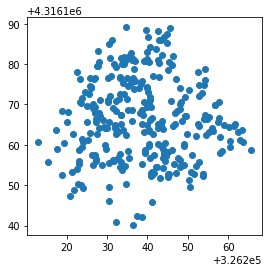

In [140]:
# Plot to check
print(er_gt1_clean.shape)
er_gt1_clean.plot();

---
## Clean ER-APU1 - Schofield 5 - appd_gpdf[6]

In [141]:
er_apu1 = appd_gpdf[6].copy()

In [142]:
#er_apu1

In [143]:
# Get rid of 'None' values and fix inconsistent entries in species code
er_apu1['Other'].replace([None], 'UNKN', inplace = True)
er_apu1['Other'].replace('ab', 'ABLA', inplace = True)

In [144]:
# create 'sp_code' field and populate with species code from 'Other' field
er_apu1['GPS_Sp_Code'] = [str(i).upper()[:4] for i in er_apu1['Other']]

# create 'Tag_Number' as first four elements in each 'Other2' entry
er_apu1['GPS_Tag_Number'] = [str(i)[:4] for i in er_apu1['Other2']]

In [145]:
# Slice out any trees with 'nt' and 'None' tag numbers
er_apu1 = er_apu1.loc[~er_apu1['GPS_Tag_Number'].str.contains('nt', na = False)]
er_apu1 = er_apu1.loc[~er_apu1['GPS_Tag_Number'].str.contains('None', na = False)]

# Slice out entries indicating transect boundaries
er_apu1 = er_apu1.loc[~er_apu1['GPS_Sp_Code'].str.startswith('T', na = False)]

In [146]:
# create 'GPS_Geotag_Association'
er_apu1['GPS_Geotag_Association'] = [str(i).upper()[i.index('-')+2:] if ('-') in i else '' for i in er_apu1['Other']]

In [147]:
er_apu1['GPS_Tag_Number'] = pd.to_numeric(er_apu1['GPS_Tag_Number'])

In [148]:
print(er_apu1.GPS_Sp_Code.unique())
print(er_apu1.GPS_Tag_Number.unique())

['PIEN' 'ABLA' 'UNKN']
[7041 7042 7043 7044 7045 7046 7047 7048 7049 7050 7051 7052 7053 7054
 7055 7056 7057 7058 7059 7060 7061 7062 7063 7064 7065 7067 7066 7068
 7069 7070 7071 7072 7073 7074 7075 7076 7077 7078 7087 7079 7080 7356
 7357 7359 7360 7362 7363 7364 7365 7367 7370 7373 7377 7376 7379 7382
 7386 7388 7389 7393 7395 7399 7404 7406 7408 7412 7232 7234 7235 7236
 7237 7238 7240 7242 7247 7251 7252 7253 7254 7262 7255 7257 7258 7259
 7263 7264 7266 7415 7416 7422 7423 7270 7271 7272 7273 7274 7275 7277
 7282 7291 7285 7305 7295 7293 7309 7313 7315 7314 7316 7317 7318 7299
 7301 7303 7311 7328 7325 7320 7330 7331 7334 7335 7336 7340 7341 7081
 7082 7083 7084 7085 7086 7088 7089 7090 7091 7092 7093 7094 7095 7096
 7097 7098 7099 7100 7101 7102 7103 7104 7105 7106 7107 7108 7109 7110
 7111 7112 7113 7120 7116 7117 7118 7115 7114 7119 7121 7122 7123 7400
 7414 7420 7421 7426 7425 7432 7433 7427 7428 7429 7430 7431 7435 7436
 7451 7437 7438 7439 7440 7442 7443 7444 7449 7447 745

In [149]:
pts_to_add = er_apu1[(er_apu1['Other'].str.contains('-')) | (er_apu1['Other2'].str.contains('-'))][['GPS_Tag_Number', 'Other', 'Other2']]

In [150]:
pts_to_add['Targets'] = [i[i.index('-')+2:] for i in pts_to_add['Other']]
pts_to_add['Targets'] = pts_to_add['Targets'].str.split(';')

In [151]:
reftags_tmp = []
for index, row in pts_to_add.iterrows():
    reftag = list(np.repeat(row['GPS_Tag_Number'], len(row['Targets'])))
    reftags_tmp.append(reftag)

In [152]:
targtags_tmp = [val for sublist in pts_to_add['Targets'] for val in sublist]
targtags_tmp = [i.strip(' ') for i in targtags_tmp]

In [153]:
dirs_tmp = [i.split(' ')[-1] for i in targtags_tmp]
dirs_tmp = ['e' if x == 'base' or x == 'touching' or x == '1' or x == '' else x for x in dirs_tmp]
dirs_tmp = ['w' if x == 'west' else x for x in dirs_tmp]

In [154]:
reftags = [val for sublist in reftags_tmp for val in sublist]
targtags = [i.split(' ')[0] for i in targtags_tmp]
dirs = dirs_tmp
dists = [.1,  1.5,  1.5,  .5,  1.5,  .8,  1.5,  1,  1.5,  .5,  .5,  .8,  .5,  .5,  .5,  1,  .05,  .4,  1,  .3,  .4,  .2,  .7,  1,  .5,  .5,  .7,  1,  .8,  1,  1,  1.5,  .3,  .05,  .05,  .1,  .15,  .75,  .4,  .35,  .4,  .3,  .2,  1,  1,  .3,  .3,  .4,  .75,  .2,  .1,  1,  .2,  1,  .05,  1,  1,  .3,  .3,  .5,  .5,  .4,  1,  1,  0,  .7,  .75,  1,  .3,  .5,  .5,  .5,  .5,  .3,  .5,  1,  1,  .5,  1,  .8,  .5,  .4,  .1,  2,  1.8,  1,  1,  0,  0.05,  .05,  .3,  .5,  .1,  .3,  .2,  .5,  .75,  .2,  .05,  .05,  .5,  .1,  .1,  .15,  .2,  .25,  .1,  .05,  .05,  1,  1,  1,  1.5,  .5,  0.1]

assert len(reftags) == len(targtags) == len(dirs) == len(dists)

In [155]:
reftags2 = [7285, 7285, 7295, 7318, 7341, 7341, 7341]
targtags2 = [7284, 7283, 7298, 7323, 7346, 7347, 7348]
dirs2 = ['n', 'n', 'n', 'n', 'w', 'n', 'n']
dists2 = [.5, 1, 1, 1, .75, 1, 1.3]
assert len(reftags) == len(targtags) == len(dirs) == len(dists)

In [156]:
newpoints_ls = []
for reftag, targtag, dirc, dist in zip(reftags, targtags, dirs, dists):
    newpoint = makenewpoint(er_apu1, reftag, targtag, dirc, dist)
    newpoints_ls.append(newpoint)

In [157]:
for reftag, targtag, dirc, dist in zip(reftags2, targtags2, dirs2, dists2):
    newpoint = makenewpoint(er_apu1, reftag, targtag, dirc, dist)
    newpoints_ls.append(newpoint)

In [158]:
er_apu1_clean = er_apu1.append(newpoints_ls, ignore_index=True)
er_apu1_clean['Site'] = 'ER-APU1'
er_apu1_clean = er_apu1_clean[[
    'Site',
    'GPS_Tag_Number',
    'GPS_Sp_Code',
    'Latitude',
    'Longitude',
    'GNSS_Heigh',
    'Horz_Prec',
    'Vert_Prec',
    'Std_Dev',
    'GPS_Time',
    'GPS_Date',
    'Rcvr_Type',
    'Corr_Type',
    'Max_PDOP',
    'Max_HDOP',
    'GPS_Geotag_Association',
    'Comment',
    'geometry'
    ]]

In [159]:
er_apu1_clean = er_apu1_clean[er_apu1_clean['GPS_Tag_Number'] != '']
er_apu1_clean.reset_index(drop = True, inplace = True)

In [160]:
fixtag_indexer = er_apu1_clean[er_apu1_clean['GPS_Tag_Number'].str.len() <= 3].index

In [161]:
fixtag_indexer

Int64Index([376, 377, 378, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391,
            392, 393, 394, 395, 396, 421, 422, 423, 424, 425, 426, 427, 428,
            429, 430, 431, 432, 433, 434, 435, 441, 442, 443, 447, 448, 449,
            450, 462, 463, 464, 477, 478, 479],
           dtype='int64')

In [162]:
fixtags = [7381, 7383, 7384, 7390, 7391, 7394, 7392, 7396, 7397, 7398, 7401, 7402, 7403, 7405, 7407, 7409, 7410, 7411, 7286, 7288, 7287, 7289, 7297, 7294, 7296, 7292, 7310, 7308, 7307, 7321, 7324, 7319, 7322, 7327, 7326, 7329, 7342, 7343, 7344, 7345, 7445, 7446, 7448, 7451, 7452, 7353]

In [163]:
er_apu1_clean.at[fixtag_indexer, 'GPS_Tag_Number'] = fixtags

In [164]:
# Print duplicates
er_apu1_clean[er_apu1_clean.duplicated(subset = 'GPS_Tag_Number', keep = False)]

,Site,GPS_Tag_Number,GPS_Sp_Code,Latitude,Longitude,GNSS_Heigh,Horz_Prec,Vert_Prec,Std_Dev,GPS_Time,GPS_Date,Rcvr_Type,Corr_Type,Max_PDOP,Max_HDOP,GPS_Geotag_Association,Comment,geometry
87,ER-APU1,7415,ABLA,38.978984733,-106.980385683,3544.793,0.9,1.1,0.344636,03:02:36pm,2020-08-09,Geo 7X,Postprocessed Code,3.1,1.9,,NaN,POINT (328457.903 4316309.064)
88,ER-APU1,7416,PIEN,38.979013276,-106.980404600,3547.278,1.1,1.2,2.154657,03:04:49pm,2020-08-09,Geo 7X,Postprocessed Code,3.9,2.4,,NaN,POINT (328456.333 4316312.267)
89,ER-APU1,7422,PIEN,38.979016982,-106.980480711,3543.918,0.5,0.6,0.208422,03:10:51pm,2020-08-09,Geo 7X,Postprocessed Code,2.9,1.7,,NaN,POINT (328449.748 4316312.822)
90,ER-APU1,7423,ABLA,38.979048365,-106.980467660,3544.911,0.5,0.6,0.037583,03:11:33pm,2020-08-09,Geo 7X,Postprocessed Code,2.9,1.7,,NaN,POINT (328450.955 4316316.281)
169,ER-APU1,7415,ABLA,38.978989863,-106.980400231,3546.051,0.6,0.7,0.344765,08:36:09am,2020-08-16,Geo 7X,Postprocessed Code,2.9,1.6,,NaN,POINT (328456.655 4316309.661)
170,ER-APU1,7416,PIEN,38.978996017,-106.980368598,3544.513,0.7,1.2,0.364060,08:37:45am,2020-08-16,Geo 7X,Postprocessed Code,3.5,1.5,7417 5CM W; 7418 30CM SW; 7419 50CM NW,NaN,POINT (328459.410 4316310.284)
173,ER-APU1,7422,PIEN,38.979030622,-106.980473596,3544.548,0.5,0.7,0.024907,08:43:47am,2020-08-16,Geo 7X,Postprocessed Code,3.0,1.9,,NaN,POINT (328450.398 4316314.323)
174,ER-APU1,7423,ABLA,38.979056911,-106.980456206,3544.066,0.7,0.6,0.042228,08:44:49am,2020-08-16,Geo 7X,Postprocessed Code,2.9,1.9,7424 10CM SW,NaN,POINT (328451.968 4316317.207)
186,ER-APU1,7451,ABLA,38.979187971,-106.980577769,3539.040,0.8,1.0,0.086831,09:21:09am,2020-08-16,Geo 7X,Postprocessed Code,2.9,2.0,,NaN,POINT (328441.753 4316331.982)
198,ER-APU1,7452,ABLA,38.979194599,-106.980588581,3540.745,0.8,1.0,0.112729,09:57:07am,2020-08-16,Geo 7X,Postprocessed Code,2.8,1.7,,NaN,POINT (328440.833 4316332.738)


In [165]:
# Drop duplicates, preserving those with highest horizontal precision
er_apu1_clean.drop([87,88,89,174,477,478,342,406,453,455,457,459], inplace = True)

In [166]:
# Reset index
er_apu1_clean.reset_index(drop = True, inplace = True)

In [167]:
# Make sure GPS Tag Number is numeric int64
er_apu1_clean['GPS_Tag_Number'] = pd.to_numeric(er_apu1_clean['GPS_Tag_Number'])
assert er_apu1_clean['GPS_Tag_Number'].dtype == 'int64'

In [168]:
# Clean up blanks and Nones
er_apu1_clean.replace(['', 'None'], np.nan, inplace = True)

(477, 18)


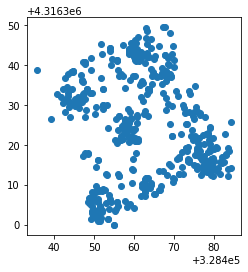

In [169]:
# Plot to check
print(er_apu1_clean.shape)
er_apu1_clean.plot();

## Clean ER-BME2 - Schofield4 - appd_gpdf[7]

In [170]:
#appd_gpdf[7]

In [171]:
er_bme2 = appd_gpdf[7].copy()

In [172]:
# Replace 'None' and erroneous values in species code
er_bme2['Other'].replace([None], 'UNKN', inplace = True)
er_bme2['Other'].replace('p', 'UNKN', inplace = True)

In [173]:
# create 'sp_code' field and populate with species code from 'Other' field
er_bme2['GPS_Sp_Code'] = [str(i).upper()[:4] for i in er_bme2['Other']]

# create 'Tag_Number' as first four elements in each 'Other2' entry
er_bme2['GPS_Tag_Number'] = [str(i)[:4] for i in er_bme2['Other2']]

# create 'GPS_Geotag_Association'
er_bme2['GPS_Geotag_Association'] = [str(i).upper()[i.index('-')+2:] if ('-') in i else '' for i in er_bme2['Other']]

In [174]:
# Slice out any trees with 'nt' and 'None' tags
er_bme2 = er_bme2.loc[~er_bme2['GPS_Sp_Code'].str.contains('SCHO', na = False)]
er_bme2.reset_index(drop = True, inplace = True)

In [175]:
er_bme2['GPS_Tag_Number'] = pd.to_numeric(er_bme2['GPS_Tag_Number'])

In [176]:
print(er_bme2['GPS_Sp_Code'].unique())
print(er_bme2['GPS_Tag_Number'].unique())

['ABLA' 'PIEN' 'UNKN']
[4157 4158 4160 4161 4167 4163 4162 4165 4171 4168 4166 4170 4169 4172
 4164 4178 4179 4177 4174 4176 4175 4180 4182 4183 4184 4185 4186 4187
 4188 4189 4190 4191 4193 4192 4194 4195 4196 4001 4003 4005 4006 4007
 4008 4010 4012 4015 4014 4018 4019 4013 4022 4021 4023 4024 4026 4027
 4030 4031 4029 4028 4025 4020 4016 4035 4034 4046 4045 4044 4039 4037
 4038 4036 4040 4041 4043 4047 4048 4049 4050 4051 4101 4103 4104 4105
 4106 4107 4108 4110 4112 4111 4115 4119 4121 4122 4120 2123 4124 4125
 4126 4137 4136 4133 4134 4129 4127 4140 4142 4144 4145 4156 4155 4149
 4146 4150 4151 4198 4199 4200 4201 4203 4205 4206 4207 4208 4209 4210
 4211 4212 4214 4215 4216 4217 4219 4220 4222 4223 4224 4225 4226 4227
 4229 4231 4232 4233 4234 4236 4237 4277 4238 4239 4241 4242 4247 4243
 4244 4245 4248 4249 4250 4253 4255 4256 4259 4260 4258 4254 4261 4263
 4264 4265 4266 4267 4268 4269 4270 4271 4272 4273 4274 4275 4276 4052
 4057 4058 4054 4053 4055 4059 4062 4056 4071 4067 406

In [177]:
pts_to_add = er_bme2[(er_bme2['Other'].str.contains('-')) | (er_bme2['Other2'].str.contains('-'))][['GPS_Tag_Number', 'Other', 'Other2']]

In [178]:
pts_to_add

,GPS_Tag_Number,Other,Other2
1,4158,abla - 4159 50cm s,4158 -59
18,4174,pien - 4173 touching,4174 - 73
21,4180,abla - 4181 touching,4180 - 81
37,4196,abla - 4197 50cm s,4196 - 97
38,4001,abla - 4002 70cm east,4001 - 02
39,4003,abla - 4004 10cm north,4003 - 04
44,4010,pien - 4009 70cm n; 4011 60cm e,4010 - 09;11
48,4018,pien - 4017 1m north,4018 - 17
58,4031,abla - 4032 50cm east,4031 - 32
65,4034,abla - 4033 20cm west,4034 - 33


In [179]:
pts_to_add['Targets'] = [i[i.index('-')+2:] for i in pts_to_add['Other']]
pts_to_add['Targets'] = pts_to_add['Targets'].str.split(';')
reftags_tmp = []
for index, row in pts_to_add.iterrows():
    reftag = list(np.repeat(row['GPS_Tag_Number'], len(row['Targets'])))
    reftags_tmp.append(reftag)

In [180]:
targtags_tmp = [val for sublist in pts_to_add['Targets'] for val in sublist]
targtags_tmp = [i.strip(' ') for i in targtags_tmp]

In [181]:
dirs_tmp = [i.split(' ')[-1] for i in targtags_tmp]
dirs_tmp = ['e' if x == 'base' or x == 'touching' or x == '1' or x == '' else x for x in dirs_tmp]
dirs_tmp = ['w' if x == 'west' else x for x in dirs_tmp]
dirs_tmp = ['e' if x == 'east' else x for x in dirs_tmp]
dirs_tmp = ['n' if x == 'north' else x for x in dirs_tmp]

In [182]:
reftags = [val for sublist in reftags_tmp for val in sublist]
targtags = [i.split(' ')[0] for i in targtags_tmp]
dirs = dirs_tmp
dists = [.5,  .05,  .05,  .5,  .7,  .1,  .7,  .6,  1,  .5,  .2,  .2,  1,  1,  .5,  .3,  1.5,  1,  1,  .5,  .5,  .05,  1,  1,  .5,  1,  1,  1.5,  1,  .5,  .3,  1.5,  1,  .5,  1,  1,  .05,  .05,  .5,  .75,  1,  .5,  .5,  1,  1,  .8,  .05,  .3,  .3,  .3,  .7,  1.5,  .1,  1.5,  1,  1.5,  1,  0.05,  .3,  .5,  1,  1,  1.5]

assert len(reftags) == len(targtags) == len(dirs) == len(dists)

In [183]:
newpoints_ls = []
for reftag, targtag, dirc, dist in zip(reftags, targtags, dirs, dists):
    newpoint = makenewpoint(er_bme2, reftag, targtag, dirc, dist)
    newpoints_ls.append(newpoint)

In [184]:
er_bme2_clean = er_bme2.append(newpoints_ls, ignore_index=True)
er_bme2_clean['Site'] = 'ER-BME2'
er_bme2_clean = er_bme2_clean[[
    'Site',
    'GPS_Tag_Number',
    'GPS_Sp_Code',
    'Latitude',
    'Longitude',
    'GNSS_Heigh',
    'Horz_Prec',
    'Vert_Prec',
    'Std_Dev',
    'GPS_Time',
    'GPS_Date',
    'Rcvr_Type',
    'Corr_Type',
    'Max_PDOP',
    'Max_HDOP',
    'GPS_Geotag_Association',
    'Comment',
    'geometry'
    ]]

In [185]:
fixtag_indexer = er_bme2_clean[er_bme2_clean['GPS_Tag_Number'].str.len() <= 3].index

In [186]:
fixtag_indexer

Int64Index([231, 232, 233, 234, 235, 245, 246, 247, 248, 266, 267, 268, 269], dtype='int64')

In [187]:
fixtags = [4114, 4113, 4116, 4117, 4118, 4148, 4152, 4153, 4154, 4066, 4065, 4069, 4070]

In [188]:
er_bme2_clean.at[fixtag_indexer, 'GPS_Tag_Number'] = fixtags

In [189]:
# Print duplicates
er_bme2_clean[er_bme2_clean.duplicated(subset = 'GPS_Tag_Number', keep = False)]

,Site,GPS_Tag_Number,GPS_Sp_Code,Latitude,Longitude,GNSS_Heigh,Horz_Prec,Vert_Prec,Std_Dev,GPS_Time,GPS_Date,Rcvr_Type,Corr_Type,Max_PDOP,Max_HDOP,GPS_Geotag_Association,Comment,geometry
28,ER-BME2,4188,ABLA,38.983950861,-107.017868101,3226.951,1.3,1.0,0.575601,02:09:40pm,2020-08-19,Geo 7X,Postprocessed Code,5.6,4.4,,NaN,POINT (325223.074 4316931.525)
34,ER-BME2,4188,ABLA,38.983961855,-107.017836696,3231.823,2.1,2.3,1.579938,02:15:55pm,2020-08-19,Geo 7X,Postprocessed Code,16.4,13.5,,NaN,POINT (325225.822 4316932.685)
200,ER-BME2,4070,ABLA,38.983915926,-107.017721967,3226.324,0.6,1.1,0.097399,10:53:31am,2020-08-13,Geo 7X,Postprocessed Code,3.4,1.5,,NaN,POINT (325235.647 4316927.368)
269,ER-BME2,4070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,Point generated post-campaign from geotag asso...,POINT (325236.863 4316926.219)


In [190]:
# Drop duplicates, preserving those with highest horizontal precision
er_bme2_clean.drop([34, 269], inplace = True)

In [191]:
# Reset index
er_bme2_clean.reset_index(drop = True, inplace = True)

In [192]:
# Make sure GPS Tag Number is numeric int64
er_bme2_clean['GPS_Tag_Number'] = pd.to_numeric(er_bme2_clean['GPS_Tag_Number'])
assert er_bme2_clean['GPS_Tag_Number'].dtype == 'int64'

In [193]:
# Clean up blanks and Nones
er_bme2_clean.replace(['', 'None'], np.nan, inplace = True)

(277, 18)


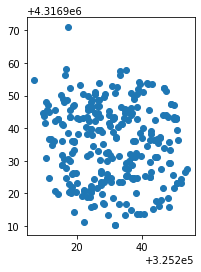

In [194]:
# Plot to check
print(er_bme2_clean.shape)
er_bme2_clean.plot();

---
## Clean CC-UC1 - Splains Gulch 1 - appd_gpdf[8]

In [195]:
cc_uc1 = appd_gpdf[8].copy()

In [196]:
# create 'Sp_code' field and populate with species code from 'Other' field
cc_uc1['GPS_Sp_Code'] = [str(i).upper()[:4] for i in cc_uc1['Other']]

# create 'Tag_Number' as first four elements in each 'Other2' entry
cc_uc1['GPS_Tag_Number'] = [str(i)[:4] for i in cc_uc1['Other2']]

# create 'GPS_Geotag_Association'
cc_uc1['GPS_Geotag_Association'] = [str(i).upper()[i.index('-')+2:] if ('-') in i else '' for i in cc_uc1['Other']]

In [197]:
#cc_uc1

In [198]:
# slice out any trees with 'nt' and 'None' tags
cc_uc1 = cc_uc1.loc[~cc_uc1['GPS_Tag_Number'].str.contains('nt', na = False)]
cc_uc1 = cc_uc1.loc[~cc_uc1['GPS_Tag_Number'].str.contains('None', na = False)]
cc_uc1.reset_index(drop = True, inplace = True)

In [199]:
cc_uc1['GPS_Tag_Number'] = pd.to_numeric(cc_uc1['GPS_Tag_Number'])

In [200]:
print(cc_uc1['GPS_Sp_Code'].unique())
print(cc_uc1['GPS_Tag_Number'].unique())

['PIEN' 'ABLA' 'UNKN']
[6071 6528 6527 6526 6534 6536 6535 6537 6538 6529 6068 6533 7601 7602
 7603 7604 7605 7606 7607 7608 7609 7610 7611 7612 7613 7615 7616 7618
 7619 7620 7621 7622 7623 7624 7625 7626 7627 7628 7629 7631 7633 7634
 7636 7635 7637 6049 6048 6047 6402 6043 6404 5887 6055 6050 5883 5882
 6406 6407 6408 6409 6410 6411 6412 6413 6414 6063 6087 6084 5878 5879
 5880 5881 5877 5876 5875 6046 5896 5897 6502 6501 5898 6503 6056 6057
 6504 6066 6510 6061 6509 6062 6060 5890 5891 5892 6059 5893 5889 5888
 6418 6058 5874 5873 5872 6419 5871 6045 6420 6090 7639 7640 7642 7643
 7646 7645 7641 7647 7648 7649 6543 6051 5885 5886 6080 6052 6053 6508
 6079 6085 6070 6086 6088 6544 6089 6541 6542 6076 6077 6069 6539 6540
 6532 6531 6530 6505 6054 6507 6506 6523 6067 6525 6524 6522 6415 6065
 6513 6064 6517 6518 6521 6520 6519 6416 6511 6514 6512 6516 6515 6074
 6417 6073 6072]


In [201]:
pts_to_add = cc_uc1[(cc_uc1['Other'].str.contains('-')) | (cc_uc1['Other2'].str.contains('-'))][['GPS_Tag_Number', 'Other', 'Other2']]

In [202]:
pts_to_add

,GPS_Tag_Number,Other,Other2
2,6527,abla58,"6527 - big scar, sappy"
8,6538,pien25,"6538 - dead, broken stem"
24,7613,abla - 7614 touching,7613 - 14
26,7616,pien - 7617 20cm north,7616 - 17
39,7631,abla - 7630 and 7632 same base; 7638 1m e,7631 - 30; 32; 38
111,7643,abla - 7644 same base,7643 - 44
127,6085,abla30,6085 - red crown
136,6076,pien21,6076 - outside plot
137,6077,pien22,6077 - outside plot
142,6531,pien53,6531 - sappy scars from deadfall


In [203]:
reftags = [7613, 7616, 7631, 7631, 7631, 7643]
targtags = [7614, 7616, 7630, 7632, 7638, 7644]
dirs = ['e', 'n', 'e', 'e', 'e', 'e']
dists = [0.05, 0.2, 0.05, 0.05, 1, 0.05]

assert len(reftags) == len(targtags) == len(dirs) == len(dists)

In [204]:
newpoints_ls = []
for reftag, targtag, dirc, dist in zip(reftags, targtags, dirs, dists):
    newpoint = makenewpoint(cc_uc1, reftag, targtag, dirc, dist)
    newpoints_ls.append(newpoint)

In [205]:
cc_uc1_clean = cc_uc1.append(newpoints_ls, ignore_index=True)
cc_uc1_clean['Site'] = 'CC-UC1'
cc_uc1_clean = cc_uc1_clean[[
    'Site',
    'GPS_Tag_Number',
    'GPS_Sp_Code',
    'Latitude',
    'Longitude',
    'GNSS_Heigh',
    'Horz_Prec',
    'Vert_Prec',
    'Std_Dev',
    'GPS_Time',
    'GPS_Date',
    'Rcvr_Type',
    'Corr_Type',
    'Max_PDOP',
    'Max_HDOP',
    'GPS_Geotag_Association',
    'Comment',
    'geometry'
    ]]

In [206]:
# Print duplicates
cc_uc1_clean[cc_uc1_clean.duplicated(subset = 'GPS_Tag_Number', keep = False)]

,Site,GPS_Tag_Number,GPS_Sp_Code,Latitude,Longitude,GNSS_Heigh,Horz_Prec,Vert_Prec,Std_Dev,GPS_Time,GPS_Date,Rcvr_Type,Corr_Type,Max_PDOP,Max_HDOP,GPS_Geotag_Association,Comment,geometry
26,CC-UC1,7616,PIEN,38.839846374,-107.064072344,3179.109,1.0,1.4,0.924394,12:30:00pm,2020-08-17,Geo 7X,Postprocessed Code,7.2,3.4,7617 20CM NORTH,NaN,POINT (320858.672 4301027.858)
65,CC-UC1,6063,PIEN,38.840102965,-107.064320863,3185.226,2.7,3.7,0.461403,08:09:38am,2020-07-27,Geo 7X,Postprocessed Code,4.6,3.7,,NaN,POINT (320837.745 4301056.823)
118,CC-UC1,6543,ABLA,38.839779281,-107.064011674,3172.057,1.0,1.2,0.257246,02:52:08pm,2020-08-17,Geo 7X,Postprocessed Code,3.1,1.5,,NaN,POINT (320863.770 4301020.292)
132,CC-UC1,6543,ABLA,38.839821476,-107.063981397,3176.901,1.4,1.7,2.126679,09:57:46am,2020-07-22,Geo 7X,Postprocessed Code,3.6,2.4,,NaN,POINT (320866.504 4301024.916)
156,CC-UC1,6063,PIEN,38.839857173,-107.064317274,3186.869,0.9,1.2,0.048699,08:59:58am,2020-07-27,Geo 7X,Postprocessed Code,3.2,1.7,,NaN,POINT (320837.440 4301029.537)
174,CC-UC1,7616,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,Point generated post-campaign from geotag asso...,POINT (320858.672 4301028.058)


In [207]:
# Drop duplicates, preserving those with highest horizontal precision
cc_uc1_clean.drop([65,132,174], inplace = True)

In [208]:
# Clean up blanks and Nones
cc_uc1_clean.replace(['', 'None'], np.nan, inplace = True)

In [209]:
# Reset index
cc_uc1_clean.reset_index(drop = True, inplace = True)

In [210]:
# Make sure GPS Tag Number is numeric int64
cc_uc1_clean['GPS_Tag_Number'] = pd.to_numeric(cc_uc1_clean['GPS_Tag_Number'])
assert cc_uc1_clean['GPS_Tag_Number'].dtype == 'int64'

(176, 18)


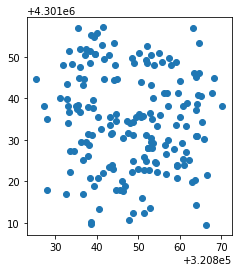

In [211]:
# Plot to check
print(cc_uc1_clean.shape)
cc_uc1_clean.plot();

---
## Skip Research Meadow - appd_gpdf[9]

In [212]:
appd_gpdf[9].head()

,Comment,Max_PDOP,Max_HDOP,Corr_Type,Rcvr_Type,GPS_Date,GPS_Time,Update_Sta,Feat_Name,Datafile,Unfilt_Pos,Filt_Pos,Data_Dicti,GPS_Week,GPS_Second,GNSS_Heigh,Vert_Prec,Horz_Prec,Std_Dev,Latitude,Longitude,Point_ID,Site,geometry
0,abla 1 [64],3.4,1.6,Postprocessed Code,Geo 7X (H-Star),2019-10-16,09:56:08am,New,Point_ge,KUEPPERSL101610A.cor,30,30,Generic,2075,320185.0,2897.823,1.0,0.6,0.066311,38.957726807,-106.987546291,1,ResearchMeadow,POINT (327786.101 4313963.279)
1,pien 1 [65],2.9,1.3,Postprocessed Code,Geo 7X (H-Star),2019-10-16,09:57:13am,New,Point_ge,KUEPPERSL101610A.cor,31,31,Generic,2075,320250.0,2895.367,1.1,0.6,0.310587,38.957749585,-106.987499581,2,ResearchMeadow,POINT (327790.204 4313965.719)
2,abla 2 [66],2.9,1.2,Postprocessed Code,Geo 7X (H-Star),2019-10-16,10:06:28am,New,Point_ge,KUEPPERSL101610A.cor,31,31,Generic,2075,320805.0,2902.577,0.6,0.3,0.066958,38.957870464,-106.986708067,3,ResearchMeadow,POINT (327859.084 4313977.638)
3,pien 2 [67],5.2,2.2,Postprocessed Code,Geo 7X (H-Star),2019-10-16,10:08:35am,New,Point_ge,KUEPPERSL101610A.cor,31,31,Generic,2075,320932.0,2912.755,0.6,0.4,0.854094,38.957885851,-106.986703857,4,ResearchMeadow,POINT (327859.486 4313979.338)
4,abla 3 [68],4.1,2.2,Postprocessed Code,Geo 7X (H-Star),2019-10-16,10:10:16am,New,Point_ge,KUEPPERSL101610A.cor,34,34,Generic,2075,321033.0,2905.542,1.0,0.6,0.813711,38.957916156,-106.986623326,5,ResearchMeadow,POINT (327866.538 4313982.549)


---
## Clean WG-WGM1 - Washington Gulch 1 - appd_gpdf[10]

In [213]:
wg_wgm1 = appd_gpdf[10].copy()

In [214]:
# create 'sp_code' field and populate with species code from 'Other' field
wg_wgm1['GPS_Sp_Code'] = [str(i).upper()[:4] for i in wg_wgm1['Other']]

# create 'Tag_Number' as first four elements in each 'Other2' entry
wg_wgm1['GPS_Tag_Number'] = [str(i)[:4] for i in wg_wgm1['Other2']]

# create 'GPS_Geotag_Association'
wg_wgm1['GPS_Geotag_Association'] = [str(i).upper()[i.index('-')+2:] if ('-') in i else '' for i in wg_wgm1['Other']]

In [215]:
# Slice out any trees with 'test' tags
wg_wgm1 = wg_wgm1.loc[wg_wgm1['GPS_Sp_Code'] != 'TEST']
wg_wgm1.reset_index(drop = True, inplace = True)

In [216]:
wg_wgm1['GPS_Tag_Number'] = pd.to_numeric(wg_wgm1['GPS_Tag_Number'])

In [217]:
print(wg_wgm1.GPS_Sp_Code.unique())
print(wg_wgm1.GPS_Tag_Number.unique())

['ABLA' 'PIEN']
[6842 6843 6844 6845 6846 6847 6848 6851 6849 6850 6852 6853 6854 6855
 6856 6857 6859 6860 6861 6862 6863 6864 6865 6866 6867 6868 6869 6870
 6871 6872 6873 6874 6875 6876 6877 6878 6879 6882 6880 6881 6885 6884
 6883 6926 6925 6924 6923 6922 6921 6920 6919 6918 6917 6916 6915 6914
 6913 6912 6911 6910 6909 6761 6762 6763 6764 6765 6766 6908 6907 6906
 6905 6904 6903 6902 6901 6900 6899 6898 9897 6896 6895 6927 6894 6893
 6892 6991 6890 6889 6888 6887 6886 6826 6858 6742 6743 6744 6745 6746
 6747 6748 6749 6750 6751 6767 6768 6769 6770 6771 6772 6776 6773 6774
 6775 6777 6778 6779 6780 6781 6782 6783 6784 6785 6786 6787 6788 6789
 6790 6791 6792 6793 6794 6795 6796 6797 6798 6799 6800 6801 6802 6803
 6804 6805 6806 6807 6808 6809 6810 6811 6812 6813 6814 6815 6816 6817
 6818 6819 6820 6821 6822 6823 6824 6825 6827 6828 6829 6830 6831 6832
 6833 6834 6835 6836 6837 6838 6839 6840 6841 6701 6702 6703 6704 6705
 6706 6707 6708 6709 6710 6711 6712 6713 6715 6716 6717 6718 

In [218]:
wg_wgm1.GPS_Geotag_Association.unique()

array([''], dtype=object)

No geotag associations noted, so no points to add.

In [219]:
wg_wgm1_clean = wg_wgm1.copy()
wg_wgm1_clean['Comment'] = np.nan
wg_wgm1_clean['Site'] = 'WG-WGM1'
wg_wgm1_clean = wg_wgm1_clean[[
    'Site',
    'GPS_Tag_Number',
    'GPS_Sp_Code',
    'Latitude',
    'Longitude',
    'GNSS_Heigh',
    'Horz_Prec',
    'Vert_Prec',
    'Std_Dev',
    'GPS_Time',
    'GPS_Date',
    'Rcvr_Type',
    'Corr_Type',
    'Max_PDOP',
    'Max_HDOP',
    'GPS_Geotag_Association',
    'Comment',
    'geometry'
    ]]

In [220]:
# Print duplicates
wg_wgm1_clean[wg_wgm1_clean.duplicated(subset = 'GPS_Tag_Number', keep = False)]

,Site,GPS_Tag_Number,GPS_Sp_Code,Latitude,Longitude,GNSS_Heigh,Horz_Prec,Vert_Prec,Std_Dev,GPS_Time,GPS_Date,Rcvr_Type,Corr_Type,Max_PDOP,Max_HDOP,GPS_Geotag_Association,Comment,geometry
189,WG-WGM1,6713,ABLA,38.948586859,-107.026524379,3093.848,2.5,3.4,0.428413,10:08:11am,2020-08-05,Geo 7X,Postprocessed Code,6.5,1.7,,NaN,POINT (324385.909 4313023.305)
190,WG-WGM1,6713,PIEN,38.948590822,-107.026537702,3102.301,1.1,1.4,0.216018,10:09:32am,2020-08-05,Geo 7X,Postprocessed Code,6.0,2.7,,NaN,POINT (324384.764 4313023.770)


In [221]:
# Drop duplicates, preserving those with highest horizontal precision
wg_wgm1_clean.drop(189, inplace = True)

# Species is coded incorrectly in preserved entry - should be ABLA
wg_wgm1_clean.at[190, 'GPS_Sp_Code'] = 'ABLA'

In [222]:
# Clean up blanks and Nones
wg_wgm1_clean.replace(['', 'None'], np.nan, inplace = True)

In [223]:
# Reset index
wg_wgm1_clean.reset_index(drop = True, inplace = True)

In [224]:
# Make sure GPS Tag Number is numeric int64
wg_wgm1_clean['GPS_Tag_Number'] = pd.to_numeric(wg_wgm1_clean['GPS_Tag_Number'])
assert wg_wgm1_clean['GPS_Tag_Number'].dtype == 'int64'

(225, 18)


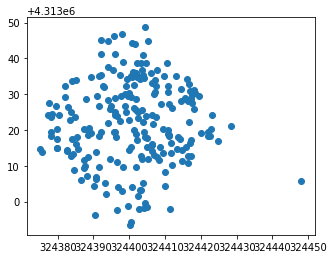

In [225]:
# Plot to check
print(wg_wgm1_clean.shape)
wg_wgm1_clean.plot();

---
## Clean CC-UC2 - Ohio Pass 1 - appd_gpdf[11]

In [248]:
cc_uc2 = appd_gpdf[11].copy()

In [249]:
# Replace 'None' and erroneous values in species code
cc_uc2['Other'].replace([None], 'UNKN', inplace = True)
cc_uc2['Other'].replace('a', 'ABLA', inplace = True)

In [250]:
# slice out any trees with 'nt' and 'None' tags
cc_uc2 = cc_uc2.loc[~cc_uc2['Other2'].str.contains('nt', na = False)]
cc_uc2 = cc_uc2.loc[~cc_uc2['Other2'].str.contains('None', na = False)]
cc_uc2 = cc_uc2.loc[~cc_uc2['Other'].str.contains('ohio', na = False)]
cc_uc2.reset_index(drop = True, inplace = True)

In [251]:
# create 'sp_code' field and populate with species code from 'Other' field
cc_uc2['GPS_Sp_Code'] = [str(i).upper()[:4] for i in cc_uc2['Other']]

# create 'Tag_Number' as first four elements in each 'Other2' entry
cc_uc2['GPS_Tag_Number'] = [str(i)[:4] for i in cc_uc2['Other2']]

# create 'GPS_Geotag_Association'
cc_uc2['GPS_Geotag_Association'] = [str(i).upper()[i.index('-')+2:] if ('-') in i else '' for i in cc_uc2['Other']]
cc_uc2['GPS_Geotag_Association'] = [str(i).upper()[i.index('-')+2:] if 'm' in i else j for i,j in zip(cc_uc2['Other2'],cc_uc2['GPS_Geotag_Association'])]

In [252]:
cc_uc2['GPS_Tag_Number'] = pd.to_numeric(cc_uc2['GPS_Tag_Number'])

In [255]:
print(cc_uc2.GPS_Sp_Code.unique())
print(cc_uc2.GPS_Tag_Number.unique())
print(cc_uc2.GPS_Geotag_Association.unique())

['ABLA' 'PIEN' 'UNKN']
[3651 3652 3653 3654 3655 3656 3657 3658 3659 3660 3661 3662 3663 3664
 3665 3666 3667 3668 3672 3671 3669 3670 3680 3679 3678 3677 3676 3675
 3673 3674 3682 3681 3683 3684 3685 3686 3687 3689 3688 3690 3691 3692
 3693 3694 3695 3696 3697 3698 3699 3700 3724 3725 3726 3727 3728 3729
 3730 3731 3732 3733 3734 3735 3736 3737 3738 3739 3740 3741 3742 3743
 3744 3745 3746 3747 3750 3749 3748 3751 3752 3753 3754 3755 3756 3757
 3758 3763 3762 3759 3760 3761 3764 3765 3766 3767 3768 3769 3770 3771
 3772 3773 3774 3775 3776 3777 3778 3779 3780 3951 3950 3949 3948 3946
 3945 3944 3943 3942 3941 3940 3939 3937 3936 3935 3934 3933 3932 3931
 3930 3929 3928 3927 3926 3925 3924 3923 3922 3921 3920 3919 3918 3917
 3916 3915 3914 3913 3912 3802 3803 3804 3814 3805 3806 3807 3808 3811
 3816 3817 3821 3820 3818 3822 3823 3824 3825 3826 3827 3829 3832 3834
 3835 3836 3838 3839 3840 3841 3842 3845 3846 3847 3848 3849 3850 3851
 3852 3853 3859 3856 3873 3812 3876 3877 3878 3879 388

In [256]:
pts_to_add = cc_uc2[(cc_uc2['Other'].str.contains('-')) | (cc_uc2['Other2'].str.contains('-'))][['GPS_Tag_Number', 'Other', 'Other2', 'GPS_Geotag_Association']]

In [257]:
pts_to_add

,GPS_Tag_Number,Other,Other2,GPS_Geotag_Association
113,3946,pien - 3947 15cm nw,3946 - 47,3947 15CM NW
121,3937,abla - 3938 same base,3937 - 38,3938 SAME BASE
150,3814,pien - 3815 10cm n; 3813 1m w,3814 - 13; 15,3815 10CM N; 3813 1M W
154,3808,abla - 3809 1m e; 3810 1.5m n,3808 - 09; 10,3809 1M E; 3810 1.5M N
160,3818,abla - 3819 10cm n,3818 - 19,3819 10CM N
167,3829,abla - 3828 1m s; 3830 1m n,3829 - 28; 30,3828 1M S; 3830 1M N
168,3832,abla - 3831 1m s,3832 - 31,3831 1M S
169,3834,abla - 3833 1m s,3834 - 33,3833 1M S
172,3838,abla - 3837 touching,3838 - 37,3837 TOUCHING
176,3842,pien - 3843 1.5m e,3842 - 43,3843 1.5M E


In [258]:
reftags = [3946, 3937, 3814, 3814, 3808, 3808, 3819, 3829, 3829, 3832, 3834, 3838, 3842, 3845, 3859, 3859, 3856, 3856, 3882, 3882, 3890, 3890, 3890, 3902, 3909, 3632, 3791, 3791, 3791, 3872, 3868, 3868, 3879, 3883]
targtags = [3947, 3938, 3815, 3813, 3809, 3810, 3819, 3828, 3830, 3831, 3833, 3837, 3843, 3844, 3860, 3858, 3855, 3857, 3883, 3884, 3889, 3891, 3892, 3903, 3910, 3633, 3792, 3793, 3794, 3871, 3867, 3869, 3878, 3881]
dirs = ['nw', 'e', 'n', 'w', 'e', 'n', 'n', 's', 'n', 's', 's', 'e', 'e', 'se', 'w', 'e', 'e', 'nw', 'se', 's', 'n', 'e', 'se', 'ne', 's', 'se', 'w', 'e', 's', 'e', 'n', 'e', 'w', 'n']
dists = [.15, .05, .1, 1, 1, 1.5, .1, 1, 1, 1, 1, .05, 1.5, 1, 1, 1, 1, 1, .2, .9, .05, .05, .1, 1, .3, .2, 1, 1, 1, 1, 1, .7, 1, 1]

assert len(reftags) == len(targtags) == len(dirs) == len(dists)

In [259]:
newpoints_ls = []
for reftag, targtag, dirc, dist in zip(reftags, targtags, dirs, dists):
    newpoint = makenewpoint(cc_uc2, reftag, targtag, dirc, dist)
    newpoints_ls.append(newpoint)

In [279]:
cc_uc2_clean = cc_uc2.append(newpoints_ls, ignore_index=True)
cc_uc2_clean['Site'] = 'CC-UC2'
cc_uc2_clean = cc_uc2_clean[[
    'Site',
    'GPS_Tag_Number',
    'GPS_Sp_Code',
    'Latitude',
    'Longitude',
    'GNSS_Heigh',
    'Horz_Prec',
    'Vert_Prec',
    'Std_Dev',
    'GPS_Time',
    'GPS_Date',
    'Rcvr_Type',
    'Corr_Type',
    'Max_PDOP',
    'Max_HDOP',
    'GPS_Geotag_Association',
    'Comment',
    'geometry'
    ]]

In [280]:
# Print duplicates
cc_uc2_clean[cc_uc2_clean.duplicated(subset = 'GPS_Tag_Number', keep = False)]

,Site,GPS_Tag_Number,GPS_Sp_Code,Latitude,Longitude,GNSS_Heigh,Horz_Prec,Vert_Prec,Std_Dev,GPS_Time,GPS_Date,Rcvr_Type,Corr_Type,Max_PDOP,Max_HDOP,GPS_Geotag_Association,Comment,geometry
18,CC-UC2,3672,ABLA,38.829347168,-107.082798190,3218.306,1.1,1.6,1.004234,09:44:49am,2020-08-12,Geo 7X,Postprocessed Code,5.3,1.7,,NaN,POINT (319206.717 4299899.521)
19,CC-UC2,3671,PIEN,38.829382630,-107.082740214,3228.115,0.8,1.3,1.027215,09:46:16am,2020-08-12,Geo 7X,Postprocessed Code,2.9,1.3,,NaN,POINT (319211.839 4299903.342)
28,CC-UC2,3671,PIEN,38.829374447,-107.082757701,3226.660,0.6,1.0,0.051686,09:52:00am,2020-08-12,Geo 7X,Postprocessed Code,3.1,1.5,,NaN,POINT (319210.301 4299902.469)
31,CC-UC2,3672,ABLA,38.829372895,-107.082791956,3224.971,2.3,3.0,0.262088,09:54:10am,2020-08-12,Geo 7X,Postprocessed Code,12.5,3.6,,NaN,POINT (319207.323 4299902.364)
190,CC-UC2,3876,ABLA,38.829633108,-107.082629747,3225.264,2.5,2.4,0.550196,02:31:27pm,2020-08-15,Geo 7X (H-Star),Postprocessed Code,11.4,8.1,,NaN,POINT (319222.063 4299930.923)
191,CC-UC2,3877,PIEN,38.829599928,-107.082588709,3223.277,1.4,1.5,1.576653,02:32:42pm,2020-08-15,Geo 7X (H-Star),Postprocessed Code,3.5,2.7,,NaN,POINT (319225.542 4299927.159)
192,CC-UC2,3878,PIEN,38.829630359,-107.082573445,3225.018,1.3,1.4,0.121423,02:33:24pm,2020-08-15,Geo 7X (H-Star),Postprocessed Code,3.9,2.0,,NaN,POINT (319226.944 4299930.506)
193,CC-UC2,3879,ABLA,38.829609956,-107.082579440,3221.549,0.9,0.8,0.110331,02:33:59pm,2020-08-15,Geo 7X (H-Star),Postprocessed Code,4.8,3.3,,NaN,POINT (319226.372 4299928.254)
194,CC-UC2,3880,ABLA,38.829591749,-107.082567573,3225.437,0.5,0.6,0.121492,02:34:40pm,2020-08-15,Geo 7X (H-Star),Postprocessed Code,2.8,1.7,,NaN,POINT (319227.356 4299926.209)
195,CC-UC2,3881,ABLA,38.829605222,-107.082573317,3223.259,0.7,0.7,0.444097,02:35:19pm,2020-08-15,Geo 7X (H-Star),Postprocessed Code,6.2,4.2,,NaN,POINT (319226.891 4299927.716)


In [281]:
# Drop duplicates, preserving those with highest horizontal precision
cc_uc2_clean.drop([31, 19, 190, 191, 358, 301, 302, 360, 340, 344, 359], inplace = True)

In [283]:
# Clean up blanks and Nones
cc_uc2_clean.replace(['', 'None'], np.nan, inplace = True)

In [284]:
# Reset index
cc_uc2_clean.reset_index(drop = True, inplace = True)

In [288]:
# Make sure GPS Tag Number is numeric int64
cc_uc2_clean['GPS_Tag_Number'] = pd.to_numeric(cc_uc2_clean['GPS_Tag_Number'])
assert cc_uc2['GPS_Tag_Number'].dtype == 'int64'

(350, 18)


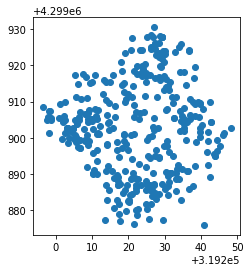

In [289]:
# Plot to check
print(cc_uc2_clean.shape)
cc_uc2_clean.plot();

---
## Assemble cleaned dataframes into list and export shapefiles

In [305]:
# Assemble list
clean_list = [
    er_bme1_clean,
    sg_nes2_clean,
    sg_swr1_clean,
    er_apl1_clean,
    xx_pln1_clean,
    er_gt1_clean,
    er_apu1_clean,
    er_bme2_clean,
    cc_uc1_clean,
    wg_wgm1_clean,
    cc_uc2_clean]

In [303]:
# Check CRS match
[clean_list[i].crs == clean_list[i+1].crs for i in np.arange(len(clean_list)-1)]

SyntaxError: invalid syntax (<ipython-input-303-3bf8e108a1af>, line 1)